# Aligning HST images to an absolute reference catalog
***

<div class="alert-danger">Note: The notebook in this repository 'Initializtion.ipynb' goes over many of the basic concepts such as the setup of the environment/package installation and should be read first if you are new to HST images, 'DrizzlePac' or 'Astroquery'.</div>

<div class="alert-warning">Note: This notebook is based on WFC3 ISR 2017-19: <a href="http://www.stsci.edu/hst/wfc3/documents/ISRs/WFC3-2017-19.pdf">Aligning HST Images to Gaia: a Faster Mosaicking Workflow</a> and contains a subset of the information/code found in <a href="https://github.com/spacetelescope/gaia_alignment">the repository here</a>.  For more information, see the notebook in that repository titled 'Gaia_alignment.ipynb'.</div>

## Introduction

The alignment of HST exposures is a critical step in image stacking/combination performed by software such as `AstroDrizzle`.  Generally, a relative alignment is performed that aligns one image (or multiple images) to another image which is designated as the reference image.  This makes it so the images are aligned to each other, but the pointing error of the observatory can still cause the images to have incorrect absolute astrometry.

When absolute astrometry is desired, the images can be aligned to an external catalog that is known to be on an absolute frame.  In this example, we will provide a workflow to query catalogs such as SDSS and Gaia via the astroquery package, and then align the images to that catalog via TweakReg.

For more information about TweakReg, see the other notebooks in this repository or the __[TweakReg Documentation](https://drizzlepac.readthedocs.io/en/deployment/tweakreg.html)__.

For more information on Astroquery, see the other notebooks in this repository or the __[Astroquery Documentation](https://astroquery.readthedocs.io/en/latest/)__.

In [1]:
import astropy.units as u
import glob
import numpy as np
import matplotlib.pyplot as plt
import os

from astropy.io import fits
from astropy.table import Table
from astropy.units import Quantity
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from astroquery.mast import Observations
from astroquery.sdss import SDSS

from ccdproc import ImageFileCollection
from IPython.display import Image

from drizzlepac import tweakreg
from drizzlepac import astrodrizzle



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


# 1. Download the Data
For this example, we will use WFC3/UVIS images of NGC 6791 from Visit 01 of proposal 12692.

In [2]:
# Get the observation records
obsTable = Observations.query_criteria(obs_id='ibwb01*', proposal_id=12692, obstype='all', filters='F606W')

# Get the listing of data products
products = Observations.get_product_list(obsTable)

# Filter the products for exposures
filtered_products = Observations.filter_products(products, productSubGroupDescription='FLC')

# Show the table
filtered_products

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str8,str3,str5,str37,str64,str1,str97,str9,str28,str11,str1,str7,str19,str5,str52,int64,str8,str6,int64
26311101,HST,image,hst_12692_01_wfc3_uvis_f606w_ibwb01xq,HAP flat-field product,D,mast:HST/product/hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits,SCIENCE,--,FLC,--,HAP-SVM,DrizzlePac 3.5.1,12692,hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits,169263360,23896887,PUBLIC,2
26311085,HST,image,hst_12692_01_wfc3_uvis_f606w_ibwb01xr,HAP flat-field product,D,mast:HST/product/hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits,SCIENCE,--,FLC,--,HAP-SVM,DrizzlePac 3.5.1,12692,hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits,169148160,23896888,PUBLIC,2
26311106,HST,image,hst_12692_01_wfc3_uvis_f606w_ibwb01xx,HAP flat-field product,D,mast:HST/product/hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits,SCIENCE,--,FLC,--,HAP-SVM,DrizzlePac 3.5.1,12692,hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits,169263360,23896891,PUBLIC,2
23896887,HST,image,ibwb01xqq,DADS FLC file - CTE-corrected calibrated exposure ACS/WFC3,S,mast:HST/product/ibwb01xqq_flc.fits,SCIENCE,Minimum Recommended Products,FLC,--,CALWF3,3.6.2 (May-27-2021),12692,ibwb01xqq_flc.fits,169148160,23896887,PUBLIC,2
23896888,HST,image,ibwb01xrq,DADS FLC file - CTE-corrected calibrated exposure ACS/WFC3,S,mast:HST/product/ibwb01xrq_flc.fits,SCIENCE,Minimum Recommended Products,FLC,--,CALWF3,3.6.2 (May-27-2021),12692,ibwb01xrq_flc.fits,169032960,23896888,PUBLIC,2
23896891,HST,image,ibwb01xxq,DADS FLC file - CTE-corrected calibrated exposure ACS/WFC3,S,mast:HST/product/ibwb01xxq_flc.fits,SCIENCE,Minimum Recommended Products,FLC,--,CALWF3,3.6.2 (May-27-2021),12692,ibwb01xxq_flc.fits,169148160,23896891,PUBLIC,2


In [3]:
# Download all the images above
Observations.download_products(filtered_products, mrp_only=False)

Local Path,Status,Message,URL
str103,str8,object,object
./mastDownload/HST/hst_12692_01_wfc3_uvis_f606w_ibwb01xq/hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits,COMPLETE,None,None
./mastDownload/HST/hst_12692_01_wfc3_uvis_f606w_ibwb01xr/hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits,COMPLETE,None,None
./mastDownload/HST/hst_12692_01_wfc3_uvis_f606w_ibwb01xx/hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits,COMPLETE,None,None
./mastDownload/HST/ibwb01xqq/ibwb01xqq_flc.fits,COMPLETE,None,None
./mastDownload/HST/ibwb01xrq/ibwb01xrq_flc.fits,COMPLETE,None,None
./mastDownload/HST/ibwb01xxq/ibwb01xxq_flc.fits,COMPLETE,None,None


In [4]:
# For convenience, move the products into the current directory.
for flc in glob.glob('./mastDownload/HST/*/*flc.fits'):
    flc_name = os.path.split(flc)[-1]
    os.rename(flc, flc_name)

### Inspect the image header

The cell below shows how to query information from the image header using `ImageFileCollection` in `ccdproc`. 
We see that the 1st exposure is 30 seconds and the 2nd and 3rd exposures are 360 seconds. The 3rd exposure is dithered by ~82" in the Y-direction which is approximately the width of one UVIS chip. 

In [5]:
collec = ImageFileCollection('./', glob_include="*flc.fits", ext=0,
                             keywords=["targname", "ra_targ", "dec_targ", "filter", "exptime", "postarg1", "postarg2"])

table = collec.summary
table['exptime'].format = '7.1f'
table['ra_targ'].format = '7.7f'
table['dec_targ'].format = '7.7f'
table['postarg1'].format = '7.2f'
table['postarg2'].format = '7.2f'
table

file,targname,ra_targ,dec_targ,filter,exptime,postarg1,postarg2
str46,str8,float64,float64,str5,float64,float64,float64
hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits,NGC-6791,290.2247917,37.8026667,F606W,30.0,0.00,0.00
hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits,NGC-6791,290.2247917,37.8026667,F606W,360.0,0.00,0.00
hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits,NGC-6791,290.2247917,37.8026667,F606W,360.0,0.00,81.60
ibwb01xqq_flc.fits,NGC-6791,290.2247917,37.8026667,F606W,30.0,0.00,0.00
ibwb01xrq_flc.fits,NGC-6791,290.2247917,37.8026667,F606W,360.0,0.00,0.00
ibwb01xxq_flc.fits,NGC-6791,290.2247917,37.8026667,F606W,360.0,0.00,81.60


# 2. Querying catalogs

Now that we have the images, we will download the reference catalogs from both SDSS and Gaia using `astroquery`.

### 2a. Identify Coordinates
We will first create a SkyCoord Object to point astroquery to where we are looking on the sky.  Since our example uses data from NGC 6791, we will use the `ra_targ` and `dec_targ` keywords from the first image to get the coordinates of the object.

In [6]:
RA = table['ra_targ'][0]
Dec = table['dec_targ'][0]

### 2b. SDSS Query
We now give those values to an astropy `SkyCoord` object, which we will pass to the SDSS.  Additionally, we use an astropy `Quantity` object to create a radius for the SDSS query.  We set the radius to 6 arcminutes to comfortably cover the area of our images. For reference UVIS detector field of view is ~2.7'x2.7' and a y-dither of 82" covers a total area on the sky of ~2.7'x4.1'.

In [7]:
coord = SkyCoord(ra=RA, dec=Dec, unit=(u.deg, u.deg))
radius = Quantity(6., u.arcmin)

Then we only need to perform the query via the `SDSS.query_region` method of `astroquery.sdss`. The `spectro=False` keyword argument means we want to exclude spectroscopic objects, as we are looking for objects to match with an image.  

In the fields parameter, we specify a list of fields we want returned by the query.  In this case we only need the position, and maybe a magnitude 'g' if we want to cut very dim and/or bright objects out of the catalog, as those are likely measured poorly. Details on selecting objects by magnitude may be found in the original ['Gaia_alignment' notebook](https://github.com/spacetelescope/gaia_alignment).  Many other fields are available in the SDSS query and are [documented here](http://cas.sdss.org/dr7/en/help/browser/description.asp?n=PhotoObj&t=V).

In [8]:
sdss_query = SDSS.query_region(coord, radius=radius, spectro=False, fields=['ra', 'dec', 'g'])
sdss_query

ra,dec,g
float64,float64,float64
290.207469231001,37.8165326473223,20.33007
290.271475371735,37.7300895794016,15.66874
290.309189927802,37.8278826035946,19.63535
290.163019147038,37.7061662746003,18.96654
290.20638291091,37.8578498261682,19.08411
290.217665348487,37.7344679199735,18.97118
290.28739975944,37.8760699685096,21.61839
290.320926423694,37.8576064635757,18.07215
290.133686795983,37.8548733101238,20.47255


We then just need to save the catalog to use with TweakReg.  Since the returned value of the query is an `astropy.Table`, saving the file is very straightforward:

In [9]:
sdss_query.write('sdss.cat', format='ascii.commented_header', overwrite=True)

### 2c. Gaia Query
Similarly to SDSS, we can query Gaia catalogs for our target via `astroquery.gaia`.  We can use the same `coord` and  `radius` from the SDSS query.

In [10]:
gaia_query = Gaia.query_object_async(coordinate=coord, radius=radius)
gaia_query

INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


solution_id,DESIGNATION,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,dist
,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / mas2,1 / um,1 / um,,,,mas,,,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),dex,,deg,deg,deg,deg,,K,K,K,mag,mag,mag,mag,mag,mag,,solRad,solRad,solRad,solLum,solLum,solLum,,,
int64,object,int64,int64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,float32,float32,float64,float64,int16,bool,float32,float64,float64,float32,int16,int16,float32,int32,int16,bool,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,float32,int16,float32,float32,float32,float64,float64,int32,float32,float32,float32,object,float64,float64,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,object,object,float64
1635721458409799680,Gaia DR2 2051293319932402944,2051293319932402944,1675162907,2015.5,290.2248612117769,0.17025317759995298,37.801928644334666,0.23706526958649082,0.9169012687299769,0.2320288738061574,3.9516687,-0.7436331528144198,0.3812622579469638,6.010353940292694,0.5025560536657159,0.07765845,0.19423231,-0.002706211,-0.20296262,0.26506588,-0.22303766,-0.1096294,-0.17967537,-0.07058169,-0.061190978,215,0,214,1,1.9095645,249.77103,0.6411118327127229,1.2557711706373367,31,False,0.26720327,1.39814863054866,0.05706386095029324,0.05975954,25,15,0.44619527,0,27,False,230,476.3769381965007,1.1245576505069257,423.61273,18.993488,18,136.8471182536094,8.327590887105266,16.432978,20.0108,18,577.3836822334904,8.364935664317445,69.024284,17.85826,1.4992976,0,2.1525402,1.0173111,1.1352291,--,--,0,--,--,--,NOT_AVAILABLE,69.98761815072085,10.91419930893231,302.0419654146322,59.011908313993786,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,https://gea.esac.esa.int/data-server/datalink/links?ID=http%3A%2F%2Fgeadata.esac.esa.int%2Fdata-server%2Fdatalink%2Flinks%3FID%3D2051293319932402944,,0.0007457750280585006
1635721458409799680,Gaia DR2 2051293324218263808,2051293324218263808,1595923736,2015.5,290.223279633381,1.5690004116043692,37.80283985940256

This query has returned very large number of columns. We want to pare down the catalog to make it easier to use with `TweakReg`.  
We can select only the useful columns via:

In [11]:
reduced_query = gaia_query['ra', 'dec', 'phot_g_mean_mag']
reduced_query

ra,dec,phot_g_mean_mag
deg,deg,mag
float64,float64,float32
290.2248612117769,37.801928644334666,18.993488
290.223279633381,37.80283985940256,20.828722
290.2226200636918,37.80270788854854,16.649422
290.2248310561946,37.80058642553806,17.595186
290.2225603235312,37.8039787667679,18.654873
290.22681932060266,37.80112775249116,20.771065
290.2275250867832,37.80347302560439,19.938679
290.2242323214596,37.80039574182613,20.654758


Then we write this catalog to an ascii file for use with `TweakReg`.

In [12]:
reduced_query.write('gaia.cat', format='ascii.commented_header', overwrite=True)

## 3. Running TweakReg
With the catalogs downloaded and the headers populated, we simply need to run TweakReg with each catalog passed into the `refcat` parameter. The steps below compare the astrometric residuals obtained from aligning to each `refcat`. In each test case, we set `updatehdr` to False until we are satisfied with the alignment by inspecting both the shift file and the astrometric residual plots.

### 3a. SDSS Alignment

INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 3.5.1 started at: 19:15:52.771 (24/10/2023) 


TweakReg Version 3.5.1 started at: 19:15:52.771 (24/10/2023) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version [GCC 11.4.0]


Python Version [GCC 11.4.0]


INFO:drizzlepac.util:3.9.18 (main, Aug 28 2023, 08:38:32) 


3.9.18 (main, Aug 28 2023, 08:38:32) 


INFO:drizzlepac.util:numpy Version -> 1.23.4 


numpy Version -> 1.23.4 


INFO:drizzlepac.util:astropy Version -> 5.2.1 


astropy Version -> 5.2.1 


INFO:drizzlepac.util:stwcs Version -> 1.7.2 


stwcs Version -> 1.7.2 


INFO:drizzlepac.util:photutils Version -> 1.9.0 


photutils Version -> 1.9.0 


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	exclusions :	
INFO:drizzlepac.tweakreg:	expand_refcat :	False
INFO:drizzlepac.tweakreg:	input :	*flc.fits
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	refimage :	
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	updatewcs :	False
INFO:drizzlepac.tweakreg:	verbose :	False
INFO:drizzlepac.tweakreg:	writecat :	True
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits


    hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits


INFO:drizzlepac.tweakreg:    ibwb01xrq_flc.fits


    ibwb01xrq_flc.fits


INFO:drizzlepac.tweakreg:    hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits


    hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits


INFO:drizzlepac.tweakreg:    ibwb01xxq_flc.fits


    ibwb01xxq_flc.fits


INFO:drizzlepac.tweakreg:    hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits


    hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits


INFO:drizzlepac.tweakreg:    ibwb01xqq_flc.fits


    ibwb01xqq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	3.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	False
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	*flc.fits
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	1.5
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	sharphi :	1.0
INFO:drizzlepac.tweakreg:	sharplo :	0.2
INFO:drizzlepac.tweakreg:	skysigma :	0.0
INFO:drizzlepac.tweakreg:	th

===  Source finding for image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits', EXT=('SCI', 1) started at: 19:15:52.942 (24/10/2023)


  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits', EXT=('SCI', 1) started at: 19:15:52.942 (24/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 5.607784
INFO:drizzlepac.catalogs:###Source finding finished at: 19:15:53.474 (24/10/2023)
INFO:drizzlepac.catalogs:     Found 1360 objects.


     Found 1360 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits', EXT=('SCI', 2) started at: 19:15:53.553 (24/10/2023)


  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits', EXT=('SCI', 2) started at: 19:15:53.553 (24/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 5.679634
INFO:drizzlepac.catalogs:###Source finding finished at: 19:15:54.298 (24/10/2023)
INFO:drizzlepac.catalogs:     Found 1296 objects.


     Found 1296 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits': 2656


===  FINAL number of objects in image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits': 2656


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibwb01xrq_flc.fits':


===  Source finding for image 'ibwb01xrq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xrq_flc.fits', EXT=('SCI', 1) started at: 19:15:54.915 (24/10/2023)


  #  Source finding for 'ibwb01xrq_flc.fits', EXT=('SCI', 1) started at: 19:15:54.915 (24/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 5.607784
INFO:drizzlepac.catalogs:###Source finding finished at: 19:15:55.442 (24/10/2023)
INFO:drizzlepac.catalogs:     Found 1360 objects.


     Found 1360 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xrq_flc.fits', EXT=('SCI', 2) started at: 19:15:55.517 (24/10/2023)


  #  Source finding for 'ibwb01xrq_flc.fits', EXT=('SCI', 2) started at: 19:15:55.517 (24/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 5.679634
INFO:drizzlepac.catalogs:###Source finding finished at: 19:15:56.041 (24/10/2023)
INFO:drizzlepac.catalogs:     Found 1296 objects.


     Found 1296 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibwb01xrq_flc.fits': 2656


===  FINAL number of objects in image 'ibwb01xrq_flc.fits': 2656


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits':


===  Source finding for image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits', EXT=('SCI', 1) started at: 19:15:56.661 (24/10/2023)


  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits', EXT=('SCI', 1) started at: 19:15:56.661 (24/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 0.444845
INFO:drizzlepac.catalogs:###Source finding finished at: 19:15:57.208 (24/10/2023)
INFO:drizzlepac.catalogs:     Found 2130 objects.


     Found 2130 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits', EXT=('SCI', 2) started at: 19:15:57.290 (24/10/2023)


  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits', EXT=('SCI', 2) started at: 19:15:57.290 (24/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 0.472479
INFO:drizzlepac.catalogs:###Source finding finished at: 19:15:57.837 (24/10/2023)
INFO:drizzlepac.catalogs:     Found 2097 objects.


     Found 2097 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits': 4227


===  FINAL number of objects in image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits': 4227


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibwb01xxq_flc.fits':


===  Source finding for image 'ibwb01xxq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xxq_flc.fits', EXT=('SCI', 1) started at: 19:15:58.475 (24/10/2023)


  #  Source finding for 'ibwb01xxq_flc.fits', EXT=('SCI', 1) started at: 19:15:58.475 (24/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 4.920793
INFO:drizzlepac.catalogs:###Source finding finished at: 19:15:59.014 (24/10/2023)
INFO:drizzlepac.catalogs:     Found 1825 objects.


     Found 1825 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xxq_flc.fits', EXT=('SCI', 2) started at: 19:15:59.091 (24/10/2023)


  #  Source finding for 'ibwb01xxq_flc.fits', EXT=('SCI', 2) started at: 19:15:59.091 (24/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 4.796717
INFO:drizzlepac.catalogs:###Source finding finished at: 19:15:59.635 (24/10/2023)
INFO:drizzlepac.catalogs:     Found 1992 objects.


     Found 1992 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibwb01xxq_flc.fits': 3817


===  FINAL number of objects in image 'ibwb01xxq_flc.fits': 3817


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits':


===  Source finding for image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits', EXT=('SCI', 1) started at: 19:16:00.156 (24/10/2023)


  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits', EXT=('SCI', 1) started at: 19:16:00.156 (24/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 4.920793
INFO:drizzlepac.catalogs:###Source finding finished at: 19:16:00.696 (24/10/2023)
INFO:drizzlepac.catalogs:     Found 1825 objects.


     Found 1825 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits', EXT=('SCI', 2) started at: 19:16:00.779 (24/10/2023)


  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits', EXT=('SCI', 2) started at: 19:16:00.779 (24/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 4.796717
INFO:drizzlepac.catalogs:###Source finding finished at: 19:16:01.321 (24/10/2023)
INFO:drizzlepac.catalogs:     Found 1992 objects.


     Found 1992 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits': 3817


===  FINAL number of objects in image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits': 3817


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibwb01xqq_flc.fits':


===  Source finding for image 'ibwb01xqq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xqq_flc.fits', EXT=('SCI', 1) started at: 19:16:01.835 (24/10/2023)


  #  Source finding for 'ibwb01xqq_flc.fits', EXT=('SCI', 1) started at: 19:16:01.835 (24/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 0.444845
INFO:drizzlepac.catalogs:###Source finding finished at: 19:16:02.383 (24/10/2023)
INFO:drizzlepac.catalogs:     Found 2130 objects.


     Found 2130 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xqq_flc.fits', EXT=('SCI', 2) started at: 19:16:02.464 (24/10/2023)


  #  Source finding for 'ibwb01xqq_flc.fits', EXT=('SCI', 2) started at: 19:16:02.464 (24/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 0.472479
INFO:drizzlepac.catalogs:###Source finding finished at: 19:16:03.014 (24/10/2023)
INFO:drizzlepac.catalogs:     Found 2097 objects.


     Found 2097 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibwb01xqq_flc.fits': 4227


===  FINAL number of objects in image 'ibwb01xqq_flc.fits': 4227


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for the reference image (not used):
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	3.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	False
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	*flc.fits
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	1.5
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	sharphi :	1.0
INFO:drizzlepac.tweakreg:	sharplo :	0.2
INFO:drizzlepac.tweakreg:	sky

INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits'


derived from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:
INFO:drizzlepac.tweakreg:	minobj :	15
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	searchrad :	1.0
INFO:drizzlepac.tweakreg:	searchunits :	arcseconds
INFO:drizzlepac.tweakreg:	see2dplot :	False
INFO:drizzlepac.tweakreg:	separation :	0.5
INFO:drizzlepac.tweakreg:	tolerance :	1.0
INFO:drizzlepac.tweakreg:	use2dhist :	True
INFO:drizzlepac.tweakreg:	xoffset :	0.0
INFO:drizzlepac.tweakreg:	yoffset :	0.0
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:
INFO:drizzlepac.tweakreg:	fitgeometry :	general
INFO:drizzlepac.tweakreg:	labelsize :	8
INFO:drizzlepac.tweakreg:	minobj :	15
INFO:drizzlepac.tweakreg:	nclip :	3
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	sigma :	3.0
INFO:drizzlepac.tweakreg:	ylimit :	1.5
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:
INFO:drizzlepac.tweakreg:

INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits


Performing fit for: hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits' with sources from reference catalog 'sdss.cat'


Matching sources from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits' with sources from reference catalog 'sdss.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 1.884, 0.6687 with significance of 70.53 and 533 matches


Found initial X and Y shifts of 1.884, 0.6687 with significance of 70.53 and 533 matches


INFO:drizzlepac.imgclasses:Found 155 matches for hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits...


Found 155 matches for hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits : 


Computed  general  fit for  hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 1.4181  YSH: 0.6344    PROPER ROT: 0.0007889248523    


XSH: 1.4181  YSH: 0.6344    PROPER ROT: 0.0007889248523    


INFO:drizzlepac.imgclasses:<ROT>: 180.0007889  SKEW: -359.9945428    ROT_X: 359.9980603  ROT_Y: 0.003517518967


<ROT>: 180.0007889  SKEW: -359.9945428    ROT_X: 359.9980603  ROT_Y: 0.003517518967


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999527199  SCALE_X: 1.000021063  SCALE_Y: 0.9998843865


<SCALE>: 0.9999527199  SCALE_X: 1.000021063  SCALE_Y: 0.9998843865


INFO:drizzlepac.imgclasses:FIT XRMS: 0.36       FIT YRMS: 0.34   


FIT XRMS: 0.36       FIT YRMS: 0.34   


INFO:drizzlepac.imgclasses:FIT RMSE: 0.49       FIT MAE: 0.43   


FIT RMSE: 0.49       FIT MAE: 0.43   


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 6.7e-06 (deg)   RMS_DEC: 1.2e-06 (deg)


RMS_RA: 6.7e-06 (deg)   RMS_DEC: 1.2e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  151  objects.


Final solution based on  151  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc_catalog_fit.match


wrote XY data to:  hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 151


Total # points: 151


INFO:drizzlepac.tweakutils:# of points after clipping: 151


# of points after clipping: 151


INFO:drizzlepac.tweakutils:Total # points: 151


Total # points: 151


INFO:drizzlepac.tweakutils:# of points after clipping: 151


# of points after clipping: 151


INFO:drizzlepac.updatehdr:....Updating header for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits' ...
INFO:drizzlepac.updatehdr:Processing hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits['SCI',1]
INFO:drizzlepac.updatehdr:Updating header for hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits[1]
INFO:drizzlepac.updatehdr:Processing hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits['SCI',2]
INFO:drizzlepac.updatehdr:Updating header for hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits[4]
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibwb01xrq_flc.fits


Performing fit for: ibwb01xrq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibwb01xrq_flc.fits' with sources from reference catalog 'sdss.cat'


Matching sources from 'ibwb01xrq_flc.fits' with sources from reference catalog 'sdss.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 1.886, 0.6279 with significance of 69.24 and 533 matches


Found initial X and Y shifts of 1.886, 0.6279 with significance of 69.24 and 533 matches


INFO:drizzlepac.imgclasses:Found 153 matches for ibwb01xrq_flc.fits...


Found 153 matches for ibwb01xrq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  ibwb01xrq_flc.fits : 


Computed  general  fit for  ibwb01xrq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 1.4185  YSH: 0.6274    PROPER ROT: 0.0008224970608    


XSH: 1.4185  YSH: 0.6274    PROPER ROT: 0.0008224970608    


INFO:drizzlepac.imgclasses:<ROT>: 180.0008225  SKEW: -359.9946232    ROT_X: 359.9981341  ROT_Y: 0.003510894752


<ROT>: 180.0008225  SKEW: -359.9946232    ROT_X: 359.9981341  ROT_Y: 0.003510894752


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999469228  SCALE_X: 1.000014661  SCALE_Y: 0.9998791937


<SCALE>: 0.9999469228  SCALE_X: 1.000014661  SCALE_Y: 0.9998791937


INFO:drizzlepac.imgclasses:FIT XRMS: 0.36       FIT YRMS: 0.34   


FIT XRMS: 0.36       FIT YRMS: 0.34   


INFO:drizzlepac.imgclasses:FIT RMSE: 0.49       FIT MAE: 0.43   


FIT RMSE: 0.49       FIT MAE: 0.43   


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 6.7e-06 (deg)   RMS_DEC: 1.2e-06 (deg)


RMS_RA: 6.7e-06 (deg)   RMS_DEC: 1.2e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  151  objects.


Final solution based on  151  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ibwb01xrq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  ibwb01xrq_flc_catalog_fit.match


wrote XY data to:  ibwb01xrq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 151


Total # points: 151


INFO:drizzlepac.tweakutils:# of points after clipping: 151


# of points after clipping: 151


INFO:drizzlepac.tweakutils:Total # points: 151


Total # points: 151


INFO:drizzlepac.tweakutils:# of points after clipping: 151


# of points after clipping: 151


INFO:drizzlepac.updatehdr:....Updating header for 'ibwb01xrq_flc.fits' ...
INFO:drizzlepac.updatehdr:Processing ibwb01xrq_flc.fits['SCI',1]
INFO:drizzlepac.updatehdr:Updating header for ibwb01xrq_flc.fits[1]
INFO:drizzlepac.updatehdr:Processing ibwb01xrq_flc.fits['SCI',2]
INFO:drizzlepac.updatehdr:Updating header for ibwb01xrq_flc.fits[4]
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits


Performing fit for: hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits' with sources from reference catalog 'sdss.cat'


Matching sources from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits' with sources from reference catalog 'sdss.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 1.889, 0.8168 with significance of 81.04 and 545 matches


Found initial X and Y shifts of 1.889, 0.8168 with significance of 81.04 and 545 matches


INFO:drizzlepac.imgclasses:Found 150 matches for hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits...


Found 150 matches for hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits : 


Computed  general  fit for  hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 1.3585  YSH: 0.8146    PROPER ROT: 0.001344282908    


XSH: 1.3585  YSH: 0.8146    PROPER ROT: 0.001344282908    


INFO:drizzlepac.imgclasses:<ROT>: 180.0013443  SKEW: -359.9933688    ROT_X: 359.9980287  ROT_Y: 0.00465988191


<ROT>: 180.0013443  SKEW: -359.9933688    ROT_X: 359.9980287  ROT_Y: 0.00465988191


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999270549  SCALE_X: 1.000039078  SCALE_Y: 0.9998150508


<SCALE>: 0.9999270549  SCALE_X: 1.000039078  SCALE_Y: 0.9998150508


INFO:drizzlepac.imgclasses:FIT XRMS: 0.34       FIT YRMS: 0.3    


FIT XRMS: 0.34       FIT YRMS: 0.3    


INFO:drizzlepac.imgclasses:FIT RMSE: 0.46       FIT MAE: 0.39   


FIT RMSE: 0.46       FIT MAE: 0.39   


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 6.1e-06 (deg)   RMS_DEC: 1.3e-06 (deg)


RMS_RA: 6.1e-06 (deg)   RMS_DEC: 1.3e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  145  objects.


Final solution based on  145  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc_catalog_fit.match


wrote XY data to:  hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 145


Total # points: 145


INFO:drizzlepac.tweakutils:# of points after clipping: 145


# of points after clipping: 145


INFO:drizzlepac.tweakutils:Total # points: 145


Total # points: 145


INFO:drizzlepac.tweakutils:# of points after clipping: 145


# of points after clipping: 145


INFO:drizzlepac.updatehdr:....Updating header for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits' ...
INFO:drizzlepac.updatehdr:Processing hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits['SCI',1]
INFO:drizzlepac.updatehdr:Updating header for hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits[1]
INFO:drizzlepac.updatehdr:Processing hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits['SCI',2]
INFO:drizzlepac.updatehdr:Updating header for hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits[4]
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibwb01xxq_flc.fits


Performing fit for: ibwb01xxq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibwb01xxq_flc.fits' with sources from reference catalog 'sdss.cat'


Matching sources from 'ibwb01xxq_flc.fits' with sources from reference catalog 'sdss.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 1.935, -1.105 with significance of 89.43 and 509 matches


Found initial X and Y shifts of 1.935, -1.105 with significance of 89.43 and 509 matches


INFO:drizzlepac.imgclasses:Found 159 matches for ibwb01xxq_flc.fits...


Found 159 matches for ibwb01xxq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  ibwb01xxq_flc.fits : 


Computed  general  fit for  ibwb01xxq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 1.4793  YSH: -1.0302    PROPER ROT: 359.9999205    


XSH: 1.4793  YSH: -1.0302    PROPER ROT: 359.9999205    


INFO:drizzlepac.imgclasses:<ROT>: 179.9999205  SKEW: 359.9992183    ROT_X: 0.0003113547454  ROT_Y: 359.9995297


<ROT>: 179.9999205  SKEW: 359.9992183    ROT_X: 0.0003113547454  ROT_Y: 359.9995297


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999861856  SCALE_X: 0.999988435  SCALE_Y: 0.9999839362


<SCALE>: 0.9999861856  SCALE_X: 0.999988435  SCALE_Y: 0.9999839362


INFO:drizzlepac.imgclasses:FIT XRMS: 0.34       FIT YRMS: 0.38   


FIT XRMS: 0.34       FIT YRMS: 0.38   


INFO:drizzlepac.imgclasses:FIT RMSE: 0.52       FIT MAE: 0.45   


FIT RMSE: 0.52       FIT MAE: 0.45   


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 7.1e-06 (deg)   RMS_DEC: 7.6e-07 (deg)


RMS_RA: 7.1e-06 (deg)   RMS_DEC: 7.6e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  158  objects.


Final solution based on  158  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ibwb01xxq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  ibwb01xxq_flc_catalog_fit.match


wrote XY data to:  ibwb01xxq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 158


Total # points: 158


INFO:drizzlepac.tweakutils:# of points after clipping: 158


# of points after clipping: 158


INFO:drizzlepac.tweakutils:Total # points: 158


Total # points: 158


INFO:drizzlepac.tweakutils:# of points after clipping: 158


# of points after clipping: 158


INFO:drizzlepac.updatehdr:....Updating header for 'ibwb01xxq_flc.fits' ...
INFO:drizzlepac.updatehdr:Processing ibwb01xxq_flc.fits['SCI',1]
INFO:drizzlepac.updatehdr:Updating header for ibwb01xxq_flc.fits[1]
INFO:drizzlepac.updatehdr:Processing ibwb01xxq_flc.fits['SCI',2]
INFO:drizzlepac.updatehdr:Updating header for ibwb01xxq_flc.fits[4]
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits


Performing fit for: hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits' with sources from reference catalog 'sdss.cat'


Matching sources from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits' with sources from reference catalog 'sdss.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 1.938, -0.07173 with significance of 86.35 and 507 matches


Found initial X and Y shifts of 1.938, -0.07173 with significance of 86.35 and 507 matches


INFO:drizzlepac.imgclasses:Found 113 matches for hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits...


Found 113 matches for hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits : 


Computed  general  fit for  hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 1.5960  YSH: -0.0720    PROPER ROT: 359.9995502    


XSH: 1.5960  YSH: -0.0720    PROPER ROT: 359.9995502    


INFO:drizzlepac.imgclasses:<ROT>: 359.9995502  SKEW: 0.0001635464286    ROT_X: 359.9994684  ROT_Y: 359.999632


<ROT>: 359.9995502  SKEW: 0.0001635464286    ROT_X: 359.9994684  ROT_Y: 359.999632


INFO:drizzlepac.imgclasses:<SCALE>: 1.000077564  SCALE_X: 0.9999887043  SCALE_Y: 1.000166432


<SCALE>: 1.000077564  SCALE_X: 0.9999887043  SCALE_Y: 1.000166432


INFO:drizzlepac.imgclasses:FIT XRMS: 0.38       FIT YRMS: 0.52   


FIT XRMS: 0.38       FIT YRMS: 0.52   


INFO:drizzlepac.imgclasses:FIT RMSE: 0.64       FIT MAE: 0.58   


FIT RMSE: 0.64       FIT MAE: 0.58   


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 9e-06 (deg)   RMS_DEC: 2.1e-07 (deg)


RMS_RA: 9e-06 (deg)   RMS_DEC: 2.1e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  112  objects.


Final solution based on  112  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc_catalog_fit.match


wrote XY data to:  hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 112


Total # points: 112


INFO:drizzlepac.tweakutils:# of points after clipping: 112


# of points after clipping: 112


INFO:drizzlepac.tweakutils:Total # points: 112


Total # points: 112


INFO:drizzlepac.tweakutils:# of points after clipping: 112


# of points after clipping: 112


INFO:drizzlepac.updatehdr:....Updating header for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits' ...
INFO:drizzlepac.updatehdr:Processing hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits['SCI',1]
INFO:drizzlepac.updatehdr:Updating header for hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits[1]
INFO:drizzlepac.updatehdr:Processing hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits['SCI',2]
INFO:drizzlepac.updatehdr:Updating header for hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits[4]
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibwb01xqq_flc.fits


Performing fit for: ibwb01xqq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibwb01xqq_flc.fits' with sources from reference catalog 'sdss.cat'


Matching sources from 'ibwb01xqq_flc.fits' with sources from reference catalog 'sdss.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 1.896, 0.7956 with significance of 82.51 and 545 matches


Found initial X and Y shifts of 1.896, 0.7956 with significance of 82.51 and 545 matches


INFO:drizzlepac.imgclasses:Found 150 matches for ibwb01xqq_flc.fits...


Found 150 matches for ibwb01xqq_flc.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  ibwb01xqq_flc.fits : 


Computed  general  fit for  ibwb01xqq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 1.3988  YSH: 0.7788    PROPER ROT: 0.001119041743    


XSH: 1.3988  YSH: 0.7788    PROPER ROT: 0.001119041743    


INFO:drizzlepac.imgclasses:<ROT>: 180.001119  SKEW: -359.9941677    ROT_X: 359.9982029  ROT_Y: 0.004035192358


<ROT>: 180.001119  SKEW: -359.9941677    ROT_X: 359.9982029  ROT_Y: 0.004035192358


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999282427  SCALE_X: 1.000028169  SCALE_Y: 0.999828332


<SCALE>: 0.9999282427  SCALE_X: 1.000028169  SCALE_Y: 0.999828332


INFO:drizzlepac.imgclasses:FIT XRMS: 0.36       FIT YRMS: 0.31   


FIT XRMS: 0.36       FIT YRMS: 0.31   


INFO:drizzlepac.imgclasses:FIT RMSE: 0.47       FIT MAE: 0.4    


FIT RMSE: 0.47       FIT MAE: 0.4    


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 6.3e-06 (deg)   RMS_DEC: 1.4e-06 (deg)


RMS_RA: 6.3e-06 (deg)   RMS_DEC: 1.4e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  146  objects.


Final solution based on  146  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ibwb01xqq_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  ibwb01xqq_flc_catalog_fit.match


wrote XY data to:  ibwb01xqq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 146


Total # points: 146


INFO:drizzlepac.tweakutils:# of points after clipping: 146


# of points after clipping: 146


INFO:drizzlepac.tweakutils:Total # points: 146


Total # points: 146


INFO:drizzlepac.tweakutils:# of points after clipping: 146


# of points after clipping: 146


INFO:drizzlepac.updatehdr:....Updating header for 'ibwb01xqq_flc.fits' ...
INFO:drizzlepac.updatehdr:Processing ibwb01xqq_flc.fits['SCI',1]
INFO:drizzlepac.updatehdr:Updating header for ibwb01xqq_flc.fits[1]
INFO:drizzlepac.updatehdr:Processing ibwb01xqq_flc.fits['SCI',2]
INFO:drizzlepac.updatehdr:Updating header for ibwb01xqq_flc.fits[4]
INFO:drizzlepac.tweakutils:Writing out shiftfile : SDSS_shifts.txt


Writing out shiftfile : SDSS_shifts.txt


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


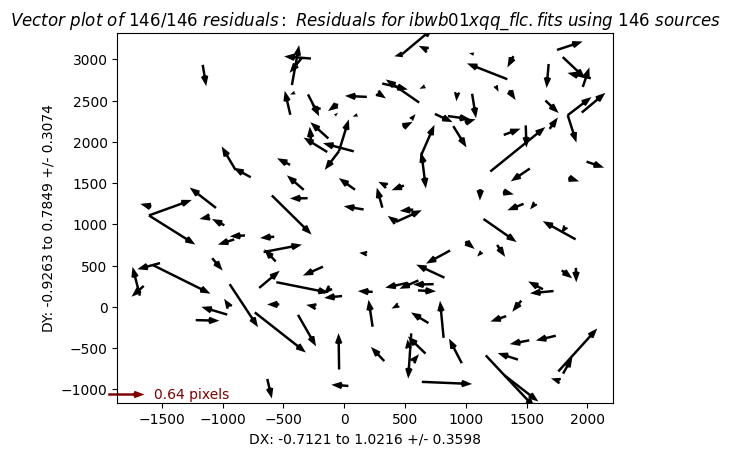

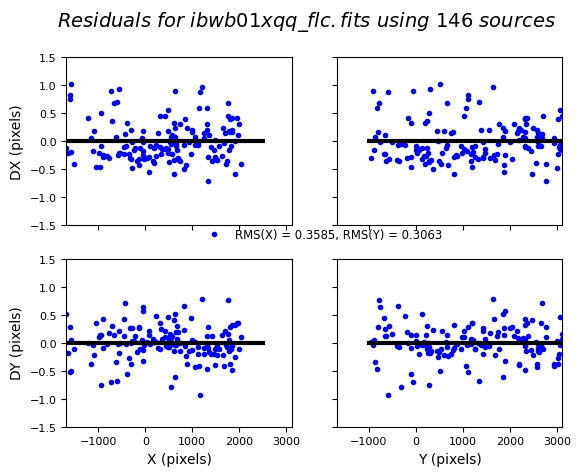

In [13]:
refcat = 'sdss.cat'
cw = 3.5  # Set to two times the FWHM of the PSF of the UVIS detector
wcsname = 'SDSS'  # Specify the WCS name for this alignment

tweakreg.TweakReg('*flc.fits',  # Pass input images
                  updatehdr=False,  # update header with new WCS solution
                  imagefindcfg={'threshold': 500., 'conv_width': cw},  # Detection parameters, threshold varies for different data
                  refcat=refcat,  # Use user supplied catalog (Gaia)
                  interactive=False,
                  see2dplot=False,
                  shiftfile=True,  # Save out shift file (so we can look at shifts later)
                  outshifts='SDSS_shifts.txt',  # name of the shift file
                  wcsname=wcsname,  # Give our WCS a new name
                  reusename=True,
                  ylimit=1.5,
                  fitgeometry='general')  # Use the 6 parameter fit

We can look at the shift file to see how well the fit did (or we could open the output png images for more information).

The columns are:
- Filename
- X Shift [pixels]
- Y Shift [pixels]
- Rotation [degrees]
- Scale
- X RMS [pixels]
- Y RMS [pixels]

In [14]:
for line in open('SDSS_shifts.txt').readlines():
    print(line)

# frame: output

# refimage: shifts_wcs.fits[wcs]

# form: delta

# units: pixels

hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits    1.418115  0.634409    0.000789     0.999953   0.360993  0.337186

ibwb01xrq_flc.fits    1.418482  0.627381    0.000822     0.999947   0.360285  0.338357

hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits    1.358525  0.814649    0.001344     0.999927   0.344135  0.298498

ibwb01xxq_flc.fits    1.479284  -1.030223    359.999921     0.999986   0.343057  0.384730

hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits    1.595993  -0.071996    359.999550     1.000078   0.375925  0.522911

ibwb01xqq_flc.fits    1.398823  0.778773    0.001119     0.999928   0.358542  0.306346



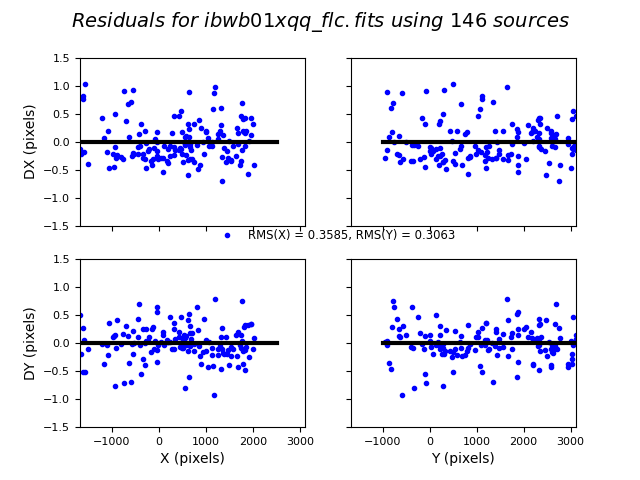

In [15]:
# Astrometric residual plots
Image(filename='residuals_ibwb01xqq_flc.png',width=500, height=300)

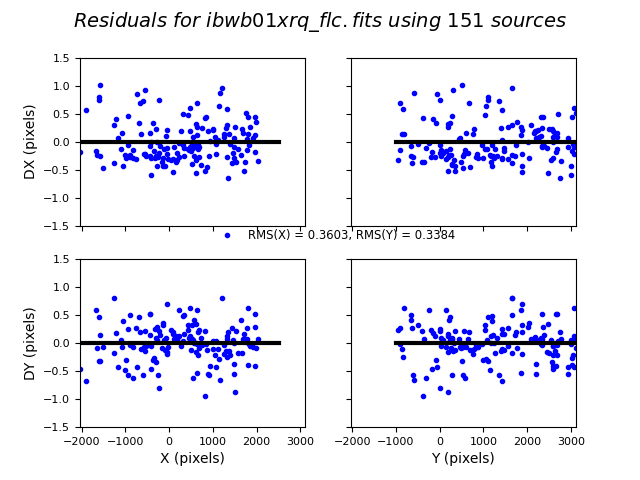

In [16]:
Image(filename='residuals_ibwb01xrq_flc.png',width=500, height=300)

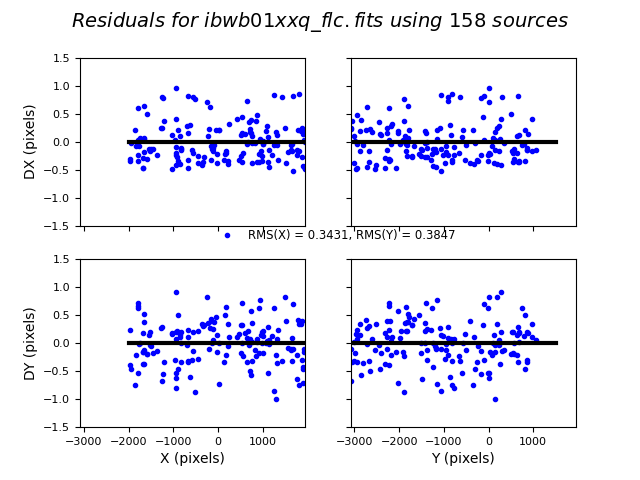

In [17]:
Image(filename='residuals_ibwb01xxq_flc.png',width=500, height=300)

As we can see, the RMS is fairly large at about 0.5 pixels, which is not a great fit. This is likely because the SDSS astrometric precision is not high enough to get good HST alignment. One approach would be to align the first image to SDSS and then align the remaining HST images to one another. This would improve both the absolute and relative alignment of the individual frames.

### 3b. Gaia Alignment

In [18]:
refcat = 'gaia.cat'
cw = 3.5  # Set to two times the FWHM of the PSF.
wcsname = 'Gaia'  # Specify the WCS name for this alignment

tweakreg.TweakReg('*flc.fits',  # Pass input images
                  updatehdr=False,  # update header with new WCS solution
                  imagefindcfg={'threshold':500.,'conv_width':cw},  # Detection parameters, threshold varies for different data
                  refcat=refcat,  # Use user supplied catalog (Gaia)
                  interactive=False,
                  see2dplot=False,
                  shiftfile=True,  # Save out shift file (so we can look at shifts later)
                  outshifts='Gaia_shifts.txt',  # name of the shift file
                  wcsname=wcsname,  # Give our WCS a new name
                  reusename=True,
                  sigma=2.3,
                  ylimit=0.2,
                  fitgeometry='general')  # Use the 6 parameter fit

INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 3.5.1 started at: 19:16:11.293 (24/10/2023) 


TweakReg Version 3.5.1 started at: 19:16:11.293 (24/10/2023) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version [GCC 11.4.0]


Python Version [GCC 11.4.0]


INFO:drizzlepac.util:3.9.18 (main, Aug 28 2023, 08:38:32) 


3.9.18 (main, Aug 28 2023, 08:38:32) 


INFO:drizzlepac.util:numpy Version -> 1.23.4 


numpy Version -> 1.23.4 


INFO:drizzlepac.util:astropy Version -> 5.2.1 


astropy Version -> 5.2.1 


INFO:drizzlepac.util:stwcs Version -> 1.7.2 


stwcs Version -> 1.7.2 


INFO:drizzlepac.util:photutils Version -> 1.9.0 


photutils Version -> 1.9.0 


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	exclusions :	
INFO:drizzlepac.tweakreg:	expand_refcat :	False
INFO:drizzlepac.tweakreg:	input :	*flc.fits
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	refimage :	
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	updatewcs :	False
INFO:drizzlepac.tweakreg:	verbose :	False
INFO:drizzlepac.tweakreg:	writecat :	True
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits


    hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits


INFO:drizzlepac.tweakreg:    ibwb01xrq_flc.fits


    ibwb01xrq_flc.fits


INFO:drizzlepac.tweakreg:    hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits


    hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits


INFO:drizzlepac.tweakreg:    ibwb01xxq_flc.fits


    ibwb01xxq_flc.fits


INFO:drizzlepac.tweakreg:    hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits


    hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits


INFO:drizzlepac.tweakreg:    ibwb01xqq_flc.fits


    ibwb01xqq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	3.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	False
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	*flc.fits
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	1.5
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	sharphi :	1.0
INFO:drizzlepac.tweakreg:	sharplo :	0.2
INFO:drizzlepac.tweakreg:	skysigma :	0.0
INFO:drizzlepac.tweakreg:	th

===  Source finding for image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits', EXT=('SCI', 1) started at: 19:16:11.476 (24/10/2023)


  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits', EXT=('SCI', 1) started at: 19:16:11.476 (24/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 5.607784
INFO:drizzlepac.catalogs:###Source finding finished at: 19:16:12.008 (24/10/2023)
INFO:drizzlepac.catalogs:     Found 1360 objects.


     Found 1360 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits', EXT=('SCI', 2) started at: 19:16:12.090 (24/10/2023)


  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits', EXT=('SCI', 2) started at: 19:16:12.090 (24/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 5.679634
INFO:drizzlepac.catalogs:###Source finding finished at: 19:16:12.619 (24/10/2023)
INFO:drizzlepac.catalogs:     Found 1296 objects.


     Found 1296 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits': 2656


===  FINAL number of objects in image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits': 2656


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibwb01xrq_flc.fits':


===  Source finding for image 'ibwb01xrq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xrq_flc.fits', EXT=('SCI', 1) started at: 19:16:13.24 (24/10/2023)


  #  Source finding for 'ibwb01xrq_flc.fits', EXT=('SCI', 1) started at: 19:16:13.24 (24/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 5.607784
INFO:drizzlepac.catalogs:###Source finding finished at: 19:16:13.772 (24/10/2023)
INFO:drizzlepac.catalogs:     Found 1360 objects.


     Found 1360 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xrq_flc.fits', EXT=('SCI', 2) started at: 19:16:13.853 (24/10/2023)


  #  Source finding for 'ibwb01xrq_flc.fits', EXT=('SCI', 2) started at: 19:16:13.853 (24/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 5.679634
INFO:drizzlepac.catalogs:###Source finding finished at: 19:16:14.380 (24/10/2023)
INFO:drizzlepac.catalogs:     Found 1296 objects.


     Found 1296 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibwb01xrq_flc.fits': 2656


===  FINAL number of objects in image 'ibwb01xrq_flc.fits': 2656


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits':


===  Source finding for image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits', EXT=('SCI', 1) started at: 19:16:15.004 (24/10/2023)


  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits', EXT=('SCI', 1) started at: 19:16:15.004 (24/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 0.444845
INFO:drizzlepac.catalogs:###Source finding finished at: 19:16:15.553 (24/10/2023)
INFO:drizzlepac.catalogs:     Found 2130 objects.


     Found 2130 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits', EXT=('SCI', 2) started at: 19:16:15.638 (24/10/2023)


  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits', EXT=('SCI', 2) started at: 19:16:15.638 (24/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 0.472479
INFO:drizzlepac.catalogs:###Source finding finished at: 19:16:16.18 (24/10/2023)
INFO:drizzlepac.catalogs:     Found 2097 objects.


     Found 2097 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits': 4227


===  FINAL number of objects in image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits': 4227


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibwb01xxq_flc.fits':


===  Source finding for image 'ibwb01xxq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xxq_flc.fits', EXT=('SCI', 1) started at: 19:16:16.746 (24/10/2023)


  #  Source finding for 'ibwb01xxq_flc.fits', EXT=('SCI', 1) started at: 19:16:16.746 (24/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 4.920793
INFO:drizzlepac.catalogs:###Source finding finished at: 19:16:17.284 (24/10/2023)
INFO:drizzlepac.catalogs:     Found 1825 objects.


     Found 1825 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xxq_flc.fits', EXT=('SCI', 2) started at: 19:16:17.363 (24/10/2023)


  #  Source finding for 'ibwb01xxq_flc.fits', EXT=('SCI', 2) started at: 19:16:17.363 (24/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 4.796717
INFO:drizzlepac.catalogs:###Source finding finished at: 19:16:17.909 (24/10/2023)
INFO:drizzlepac.catalogs:     Found 1992 objects.


     Found 1992 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibwb01xxq_flc.fits': 3817


===  FINAL number of objects in image 'ibwb01xxq_flc.fits': 3817


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits':


===  Source finding for image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits', EXT=('SCI', 1) started at: 19:16:18.427 (24/10/2023)


  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits', EXT=('SCI', 1) started at: 19:16:18.427 (24/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 4.920793
INFO:drizzlepac.catalogs:###Source finding finished at: 19:16:18.965 (24/10/2023)
INFO:drizzlepac.catalogs:     Found 1825 objects.


     Found 1825 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits', EXT=('SCI', 2) started at: 19:16:19.049 (24/10/2023)


  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits', EXT=('SCI', 2) started at: 19:16:19.049 (24/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 4.796717
INFO:drizzlepac.catalogs:###Source finding finished at: 19:16:19.68 (24/10/2023)
INFO:drizzlepac.catalogs:     Found 1992 objects.


     Found 1992 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits': 3817


===  FINAL number of objects in image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits': 3817


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibwb01xqq_flc.fits':


===  Source finding for image 'ibwb01xqq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xqq_flc.fits', EXT=('SCI', 1) started at: 19:16:20.197 (24/10/2023)


  #  Source finding for 'ibwb01xqq_flc.fits', EXT=('SCI', 1) started at: 19:16:20.197 (24/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 0.444845
INFO:drizzlepac.catalogs:###Source finding finished at: 19:16:20.746 (24/10/2023)
INFO:drizzlepac.catalogs:     Found 2130 objects.


     Found 2130 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xqq_flc.fits', EXT=('SCI', 2) started at: 19:16:20.829 (24/10/2023)


  #  Source finding for 'ibwb01xqq_flc.fits', EXT=('SCI', 2) started at: 19:16:20.829 (24/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 0.472479
INFO:drizzlepac.catalogs:###Source finding finished at: 19:16:21.37 (24/10/2023)
INFO:drizzlepac.catalogs:     Found 2097 objects.


     Found 2097 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibwb01xqq_flc.fits': 4227


===  FINAL number of objects in image 'ibwb01xqq_flc.fits': 4227


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for the reference image (not used):
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	3.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	False
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	*flc.fits
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	1.5
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	sharphi :	1.0
INFO:drizzlepac.tweakreg:	sharplo :	0.2
INFO:drizzlepac.tweakreg:	sky

INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits'


derived from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:
INFO:drizzlepac.tweakreg:	minobj :	15
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	searchrad :	1.0
INFO:drizzlepac.tweakreg:	searchunits :	arcseconds
INFO:drizzlepac.tweakreg:	see2dplot :	False
INFO:drizzlepac.tweakreg:	separation :	0.5
INFO:drizzlepac.tweakreg:	tolerance :	1.0
INFO:drizzlepac.tweakreg:	use2dhist :	True
INFO:drizzlepac.tweakreg:	xoffset :	0.0
INFO:drizzlepac.tweakreg:	yoffset :	0.0
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:
INFO:drizzlepac.tweakreg:	fitgeometry :	general
INFO:drizzlepac.tweakreg:	labelsize :	8
INFO:drizzlepac.tweakreg:	minobj :	15
INFO:drizzlepac.tweakreg:	nclip :	3
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	sigma :	2.3
INFO:drizzlepac.tweakreg:	ylimit :	0.2
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:
INFO:drizzlepac.tweakreg:

INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits


Performing fit for: hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits' with sources from reference catalog 'gaia.cat'


Matching sources from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits' with sources from reference catalog 'gaia.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.6786, 0.7806 with significance of 43.52 and 49 matches


Found initial X and Y shifts of 0.6786, 0.7806 with significance of 43.52 and 49 matches


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:# WARNING:                                                                   #


# WARNING:                                                                   #


INFO:drizzlepac.imgclasses:# Not enough matches (< 15) found for input image:                           #


# Not enough matches (< 15) found for input image:                           #


INFO:drizzlepac.imgclasses:# hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits                             #


# hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits                             #


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibwb01xrq_flc.fits


Performing fit for: ibwb01xrq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibwb01xrq_flc.fits' with sources from reference catalog 'gaia.cat'


Matching sources from 'ibwb01xrq_flc.fits' with sources from reference catalog 'gaia.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.6786, 0.7806 with significance of 43.52 and 49 matches


Found initial X and Y shifts of 0.6786, 0.7806 with significance of 43.52 and 49 matches


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:# WARNING:                                                                   #


# WARNING:                                                                   #


INFO:drizzlepac.imgclasses:# Not enough matches (< 15) found for input image: ibwb01xrq_flc.fits        #


# Not enough matches (< 15) found for input image: ibwb01xrq_flc.fits        #


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits


Performing fit for: hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits' with sources from reference catalog 'gaia.cat'


Matching sources from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits' with sources from reference catalog 'gaia.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.7202, 0.7802 with significance of 44.23 and 50 matches


Found initial X and Y shifts of 0.7202, 0.7802 with significance of 44.23 and 50 matches


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:# WARNING:                                                                   #


# WARNING:                                                                   #


INFO:drizzlepac.imgclasses:# Not enough matches (< 15) found for input image:                           #


# Not enough matches (< 15) found for input image:                           #


INFO:drizzlepac.imgclasses:# hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits                             #


# hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits                             #


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibwb01xxq_flc.fits


Performing fit for: ibwb01xxq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibwb01xxq_flc.fits' with sources from reference catalog 'gaia.cat'


Matching sources from 'ibwb01xxq_flc.fits' with sources from reference catalog 'gaia.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.538, 0.8713 with significance of 7 and 9 matches


Found initial X and Y shifts of 0.538, 0.8713 with significance of 7 and 9 matches


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:# WARNING:                                                                   #


# WARNING:                                                                   #


INFO:drizzlepac.imgclasses:# Not enough matches (< 15) found for input image: ibwb01xxq_flc.fits        #


# Not enough matches (< 15) found for input image: ibwb01xxq_flc.fits        #


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits


Performing fit for: hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits' with sources from reference catalog 'gaia.cat'


Matching sources from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits' with sources from reference catalog 'gaia.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.538, 0.8713 with significance of 7 and 9 matches


Found initial X and Y shifts of 0.538, 0.8713 with significance of 7 and 9 matches


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:# WARNING:                                                                   #


# WARNING:                                                                   #


INFO:drizzlepac.imgclasses:# Not enough matches (< 15) found for input image:                           #


# Not enough matches (< 15) found for input image:                           #


INFO:drizzlepac.imgclasses:# hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits                             #


# hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits                             #


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibwb01xqq_flc.fits


Performing fit for: ibwb01xqq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibwb01xqq_flc.fits' with sources from reference catalog 'gaia.cat'


Matching sources from 'ibwb01xqq_flc.fits' with sources from reference catalog 'gaia.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.7202, 0.7802 with significance of 44.23 and 50 matches


Found initial X and Y shifts of 0.7202, 0.7802 with significance of 44.23 and 50 matches


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:# WARNING:                                                                   #


# WARNING:                                                                   #


INFO:drizzlepac.imgclasses:# Not enough matches (< 15) found for input image: ibwb01xqq_flc.fits        #


# Not enough matches (< 15) found for input image: ibwb01xqq_flc.fits        #


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Unable to match the following images:


Unable to match the following images:


INFO:drizzlepac.tweakreg:-------------------------------------


-------------------------------------


INFO:drizzlepac.tweakreg:hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits


hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits


INFO:drizzlepac.tweakreg:ibwb01xrq_flc.fits


ibwb01xrq_flc.fits


INFO:drizzlepac.tweakreg:hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits


hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits


INFO:drizzlepac.tweakreg:ibwb01xxq_flc.fits


ibwb01xxq_flc.fits


INFO:drizzlepac.tweakreg:hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits


hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits


INFO:drizzlepac.tweakreg:ibwb01xqq_flc.fits


ibwb01xqq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakutils:Writing out shiftfile : Gaia_shifts.txt


Writing out shiftfile : Gaia_shifts.txt


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


We can similarly look at the shift file from alignment to the Gaia catalog:

In [19]:
for line in open('Gaia_shifts.txt').readlines():
    print(line)

# frame: output

# refimage: shifts_wcs.fits[wcs]

# form: delta

# units: pixels

hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits    nan  nan    nan     nan   0.000000  0.000000

ibwb01xrq_flc.fits    nan  nan    nan     nan   0.000000  0.000000

hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits    nan  nan    nan     nan   0.000000  0.000000

ibwb01xxq_flc.fits    nan  nan    nan     nan   0.000000  0.000000

hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits    nan  nan    nan     nan   0.000000  0.000000

ibwb01xqq_flc.fits    nan  nan    nan     nan   0.000000  0.000000



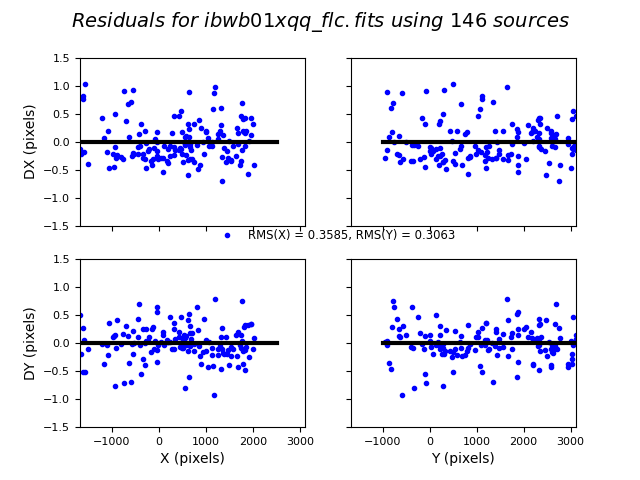

In [20]:
# Astrometric residual plots
Image(filename='residuals_ibwb01xqq_flc.png',width=500, height=300)

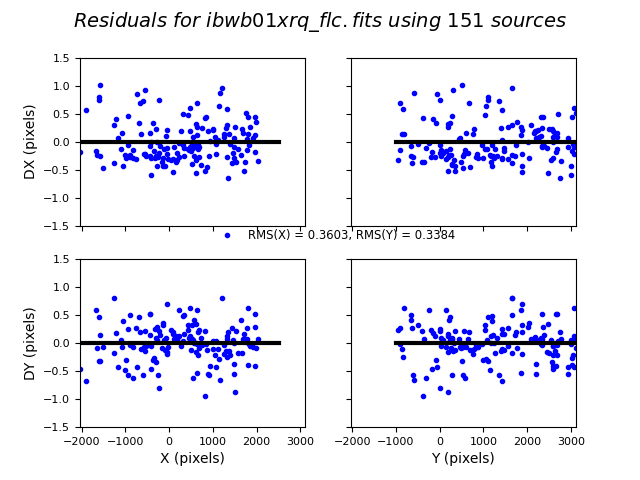

In [21]:
Image(filename='residuals_ibwb01xrq_flc.png',width=500, height=300)

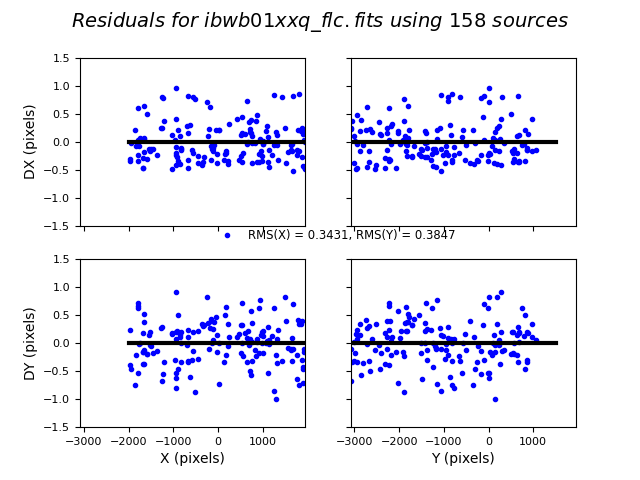

In [22]:
Image(filename='residuals_ibwb01xxq_flc.png',width=500, height=300)

As expected, the Gaia catalog does quite a bit better, with rms residuals less tha 0.05 pixels.  

To apply these transformations to the image, we simply need to run TweakReg the same as before, but set the parameter `updatehdr` equal to `True`:

In [23]:
refcat = 'gaia.cat'
cw = 3.5  # Set to two times the FWHM of the PSF.
wcsname = 'Gaia'  # Specify the WCS name for this alignment

tweakreg.TweakReg('*flc.fits',  # Pass input images
                  updatehdr=True,  # update header with new WCS solution
                  imagefindcfg={'threshold': 500., 'conv_width': cw},  # Detection parameters, threshold varies for different data
                  refcat=refcat,  # Use user supplied catalog (Gaia)
                  interactive=False,
                  see2dplot=False,
                  shiftfile=True,  # Save out shift file (so we can look at shifts later)
                  outshifts='Gaia_shifts.txt',  # name of the shift file
                  wcsname=wcsname,  # Give our WCS a new name
                  reusename=True,
                  sigma=2.3,
                  fitgeometry='general')  # Use the 6 parameter fit

INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 3.5.1 started at: 19:16:22.244 (24/10/2023) 


TweakReg Version 3.5.1 started at: 19:16:22.244 (24/10/2023) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version [GCC 11.4.0]


Python Version [GCC 11.4.0]


INFO:drizzlepac.util:3.9.18 (main, Aug 28 2023, 08:38:32) 


3.9.18 (main, Aug 28 2023, 08:38:32) 


INFO:drizzlepac.util:numpy Version -> 1.23.4 


numpy Version -> 1.23.4 


INFO:drizzlepac.util:astropy Version -> 5.2.1 


astropy Version -> 5.2.1 


INFO:drizzlepac.util:stwcs Version -> 1.7.2 


stwcs Version -> 1.7.2 


INFO:drizzlepac.util:photutils Version -> 1.9.0 


photutils Version -> 1.9.0 


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	exclusions :	
INFO:drizzlepac.tweakreg:	expand_refcat :	False
INFO:drizzlepac.tweakreg:	input :	*flc.fits
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	refimage :	
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	updatewcs :	False
INFO:drizzlepac.tweakreg:	verbose :	False
INFO:drizzlepac.tweakreg:	writecat :	True
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits


    hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits


INFO:drizzlepac.tweakreg:    ibwb01xrq_flc.fits


    ibwb01xrq_flc.fits


INFO:drizzlepac.tweakreg:    hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits


    hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits


INFO:drizzlepac.tweakreg:    ibwb01xxq_flc.fits


    ibwb01xxq_flc.fits


INFO:drizzlepac.tweakreg:    hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits


    hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits


INFO:drizzlepac.tweakreg:    ibwb01xqq_flc.fits


    ibwb01xqq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	3.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	False
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	*flc.fits
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	1.5
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	sharphi :	1.0
INFO:drizzlepac.tweakreg:	sharplo :	0.2
INFO:drizzlepac.tweakreg:	skysigma :	0.0
INFO:drizzlepac.tweakreg:	th

===  Source finding for image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits', EXT=('SCI', 1) started at: 19:16:22.762 (24/10/2023)


  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits', EXT=('SCI', 1) started at: 19:16:22.762 (24/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 5.607784
INFO:drizzlepac.catalogs:###Source finding finished at: 19:16:23.293 (24/10/2023)
INFO:drizzlepac.catalogs:     Found 1360 objects.


     Found 1360 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits', EXT=('SCI', 2) started at: 19:16:23.373 (24/10/2023)


  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits', EXT=('SCI', 2) started at: 19:16:23.373 (24/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 5.679634
INFO:drizzlepac.catalogs:###Source finding finished at: 19:16:23.89 (24/10/2023)
INFO:drizzlepac.catalogs:     Found 1296 objects.


     Found 1296 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits': 2656


===  FINAL number of objects in image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits': 2656


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibwb01xrq_flc.fits':


===  Source finding for image 'ibwb01xrq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xrq_flc.fits', EXT=('SCI', 1) started at: 19:16:24.544 (24/10/2023)


  #  Source finding for 'ibwb01xrq_flc.fits', EXT=('SCI', 1) started at: 19:16:24.544 (24/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 5.607784
INFO:drizzlepac.catalogs:###Source finding finished at: 19:16:25.076 (24/10/2023)
INFO:drizzlepac.catalogs:     Found 1360 objects.


     Found 1360 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xrq_flc.fits', EXT=('SCI', 2) started at: 19:16:25.152 (24/10/2023)


  #  Source finding for 'ibwb01xrq_flc.fits', EXT=('SCI', 2) started at: 19:16:25.152 (24/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 5.679634
INFO:drizzlepac.catalogs:###Source finding finished at: 19:16:25.676 (24/10/2023)
INFO:drizzlepac.catalogs:     Found 1296 objects.


     Found 1296 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibwb01xrq_flc.fits': 2656


===  FINAL number of objects in image 'ibwb01xrq_flc.fits': 2656


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits':


===  Source finding for image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits', EXT=('SCI', 1) started at: 19:16:26.32 (24/10/2023)


  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits', EXT=('SCI', 1) started at: 19:16:26.32 (24/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 0.444845
INFO:drizzlepac.catalogs:###Source finding finished at: 19:16:26.960 (24/10/2023)
INFO:drizzlepac.catalogs:     Found 2130 objects.


     Found 2130 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits', EXT=('SCI', 2) started at: 19:16:27.044 (24/10/2023)


  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits', EXT=('SCI', 2) started at: 19:16:27.044 (24/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 0.472479
INFO:drizzlepac.catalogs:###Source finding finished at: 19:16:27.595 (24/10/2023)
INFO:drizzlepac.catalogs:     Found 2097 objects.


     Found 2097 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits': 4227


===  FINAL number of objects in image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits': 4227


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibwb01xxq_flc.fits':


===  Source finding for image 'ibwb01xxq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xxq_flc.fits', EXT=('SCI', 1) started at: 19:16:28.18 (24/10/2023)


  #  Source finding for 'ibwb01xxq_flc.fits', EXT=('SCI', 1) started at: 19:16:28.18 (24/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 4.920793
INFO:drizzlepac.catalogs:###Source finding finished at: 19:16:28.725 (24/10/2023)
INFO:drizzlepac.catalogs:     Found 1825 objects.


     Found 1825 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xxq_flc.fits', EXT=('SCI', 2) started at: 19:16:28.805 (24/10/2023)


  #  Source finding for 'ibwb01xxq_flc.fits', EXT=('SCI', 2) started at: 19:16:28.805 (24/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 4.796717
INFO:drizzlepac.catalogs:###Source finding finished at: 19:16:29.348 (24/10/2023)
INFO:drizzlepac.catalogs:     Found 1992 objects.


     Found 1992 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibwb01xxq_flc.fits': 3817


===  FINAL number of objects in image 'ibwb01xxq_flc.fits': 3817


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits':


===  Source finding for image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits', EXT=('SCI', 1) started at: 19:16:29.898 (24/10/2023)


  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits', EXT=('SCI', 1) started at: 19:16:29.898 (24/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 4.920793
INFO:drizzlepac.catalogs:###Source finding finished at: 19:16:30.437 (24/10/2023)
INFO:drizzlepac.catalogs:     Found 1825 objects.


     Found 1825 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits', EXT=('SCI', 2) started at: 19:16:30.519 (24/10/2023)


  #  Source finding for 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits', EXT=('SCI', 2) started at: 19:16:30.519 (24/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 4.796717
INFO:drizzlepac.catalogs:###Source finding finished at: 19:16:31.062 (24/10/2023)
INFO:drizzlepac.catalogs:     Found 1992 objects.


     Found 1992 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits': 3817


===  FINAL number of objects in image 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits': 3817


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibwb01xqq_flc.fits':


===  Source finding for image 'ibwb01xqq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xqq_flc.fits', EXT=('SCI', 1) started at: 19:16:31.608 (24/10/2023)


  #  Source finding for 'ibwb01xqq_flc.fits', EXT=('SCI', 1) started at: 19:16:31.608 (24/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 0.444845
INFO:drizzlepac.catalogs:###Source finding finished at: 19:16:32.156 (24/10/2023)
INFO:drizzlepac.catalogs:     Found 2130 objects.


     Found 2130 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ibwb01xqq_flc.fits', EXT=('SCI', 2) started at: 19:16:32.236 (24/10/2023)


  #  Source finding for 'ibwb01xqq_flc.fits', EXT=('SCI', 2) started at: 19:16:32.236 (24/10/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 0.472479
INFO:drizzlepac.catalogs:###Source finding finished at: 19:16:32.784 (24/10/2023)
INFO:drizzlepac.catalogs:     Found 2097 objects.


     Found 2097 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibwb01xqq_flc.fits': 4227


===  FINAL number of objects in image 'ibwb01xqq_flc.fits': 4227


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for the reference image (not used):
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	3.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	False
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	*flc.fits
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	1.5
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	sharphi :	1.0
INFO:drizzlepac.tweakreg:	sharplo :	0.2
INFO:drizzlepac.tweakreg:	sky

INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits'


derived from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:
INFO:drizzlepac.tweakreg:	minobj :	15
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	searchrad :	1.0
INFO:drizzlepac.tweakreg:	searchunits :	arcseconds
INFO:drizzlepac.tweakreg:	see2dplot :	False
INFO:drizzlepac.tweakreg:	separation :	0.5
INFO:drizzlepac.tweakreg:	tolerance :	1.0
INFO:drizzlepac.tweakreg:	use2dhist :	True
INFO:drizzlepac.tweakreg:	xoffset :	0.0
INFO:drizzlepac.tweakreg:	yoffset :	0.0
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:
INFO:drizzlepac.tweakreg:	fitgeometry :	general
INFO:drizzlepac.tweakreg:	labelsize :	8
INFO:drizzlepac.tweakreg:	minobj :	15
INFO:drizzlepac.tweakreg:	nclip :	3
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	sigma :	2.3
INFO:drizzlepac.tweakreg:	ylimit :	None
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:
INFO:drizzlepac.tweakreg

INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits


Performing fit for: hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits' with sources from reference catalog 'gaia.cat'


Matching sources from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits' with sources from reference catalog 'gaia.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.6786, 0.7806 with significance of 43.52 and 49 matches


Found initial X and Y shifts of 0.6786, 0.7806 with significance of 43.52 and 49 matches


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:# WARNING:                                                                   #


# WARNING:                                                                   #


INFO:drizzlepac.imgclasses:# Not enough matches (< 15) found for input image:                           #


# Not enough matches (< 15) found for input image:                           #


INFO:drizzlepac.imgclasses:# hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits                             #


# hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits                             #


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibwb01xrq_flc.fits


Performing fit for: ibwb01xrq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibwb01xrq_flc.fits' with sources from reference catalog 'gaia.cat'


Matching sources from 'ibwb01xrq_flc.fits' with sources from reference catalog 'gaia.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.6786, 0.7806 with significance of 43.52 and 49 matches


Found initial X and Y shifts of 0.6786, 0.7806 with significance of 43.52 and 49 matches


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:# WARNING:                                                                   #


# WARNING:                                                                   #


INFO:drizzlepac.imgclasses:# Not enough matches (< 15) found for input image: ibwb01xrq_flc.fits        #


# Not enough matches (< 15) found for input image: ibwb01xrq_flc.fits        #


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits


Performing fit for: hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits' with sources from reference catalog 'gaia.cat'


Matching sources from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits' with sources from reference catalog 'gaia.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.7202, 0.7802 with significance of 44.23 and 50 matches


Found initial X and Y shifts of 0.7202, 0.7802 with significance of 44.23 and 50 matches


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:# WARNING:                                                                   #


# WARNING:                                                                   #


INFO:drizzlepac.imgclasses:# Not enough matches (< 15) found for input image:                           #


# Not enough matches (< 15) found for input image:                           #


INFO:drizzlepac.imgclasses:# hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits                             #


# hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits                             #


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibwb01xxq_flc.fits


Performing fit for: ibwb01xxq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibwb01xxq_flc.fits' with sources from reference catalog 'gaia.cat'


Matching sources from 'ibwb01xxq_flc.fits' with sources from reference catalog 'gaia.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.538, 0.8713 with significance of 7 and 9 matches


Found initial X and Y shifts of 0.538, 0.8713 with significance of 7 and 9 matches


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:# WARNING:                                                                   #


# WARNING:                                                                   #


INFO:drizzlepac.imgclasses:# Not enough matches (< 15) found for input image: ibwb01xxq_flc.fits        #


# Not enough matches (< 15) found for input image: ibwb01xxq_flc.fits        #


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits


Performing fit for: hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits' with sources from reference catalog 'gaia.cat'


Matching sources from 'hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits' with sources from reference catalog 'gaia.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.538, 0.8713 with significance of 7 and 9 matches


Found initial X and Y shifts of 0.538, 0.8713 with significance of 7 and 9 matches


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:# WARNING:                                                                   #


# WARNING:                                                                   #


INFO:drizzlepac.imgclasses:# Not enough matches (< 15) found for input image:                           #


# Not enough matches (< 15) found for input image:                           #


INFO:drizzlepac.imgclasses:# hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits                             #


# hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits                             #


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibwb01xqq_flc.fits


Performing fit for: ibwb01xqq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibwb01xqq_flc.fits' with sources from reference catalog 'gaia.cat'


Matching sources from 'ibwb01xqq_flc.fits' with sources from reference catalog 'gaia.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.7202, 0.7802 with significance of 44.23 and 50 matches


Found initial X and Y shifts of 0.7202, 0.7802 with significance of 44.23 and 50 matches


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:# WARNING:                                                                   #


# WARNING:                                                                   #


INFO:drizzlepac.imgclasses:# Not enough matches (< 15) found for input image: ibwb01xqq_flc.fits        #


# Not enough matches (< 15) found for input image: ibwb01xqq_flc.fits        #


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Unable to match the following images:


Unable to match the following images:


INFO:drizzlepac.tweakreg:-------------------------------------


-------------------------------------


INFO:drizzlepac.tweakreg:hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits


hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits


INFO:drizzlepac.tweakreg:ibwb01xrq_flc.fits


ibwb01xrq_flc.fits


INFO:drizzlepac.tweakreg:hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits


hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits


INFO:drizzlepac.tweakreg:ibwb01xxq_flc.fits


ibwb01xxq_flc.fits


INFO:drizzlepac.tweakreg:hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits


hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits


INFO:drizzlepac.tweakreg:ibwb01xqq_flc.fits


ibwb01xqq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Processing hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits['SCI',1]


Processing hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits['SCI',1]


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.updatehdr:Updating header for hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits[('SCI', 1)]


Updating header for hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits[('SCI', 1)]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -6.7144395879131e-06 -9.20256395233e-06


CD_11  CD_12: -6.7144395879131e-06 -9.20256395233e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -8.7983400927606e-06 6.145200238766e-06


CD_21  CD_22: -8.7983400927606e-06 6.145200238766e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 290.23990203254 37.794737093642


CRVAL    : 290.23990203254 37.794737093642


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.039843801980788275


Plate Scale : 0.039843801980788275


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -56.26617190665725


ORIENTAT : -56.26617190665725


INFO:drizzlepac.updatehdr:WCSNAME  :  Gaia


WCSNAME  :  Gaia


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Processing hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits['SCI',2]


Processing hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits['SCI',2]


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.updatehdr:Updating header for hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits[('SCI', 2)]


Updating header for hst_12692_01_wfc3_uvis_f606w_ibwb01xr_flc.fits[('SCI', 2)]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -6.7315252947809e-06 -9.0884464752709e-06


CD_11  CD_12: -6.7315252947809e-06 -9.0884464752709e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -8.7080889077681e-06 6.0806723728579e-06


CD_21  CD_22: -8.7080889077681e-06 6.0806723728579e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 290.21581143374 37.807471407735


CRVAL    : 290.21581143374 37.807471407735


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.03962359673287499


Plate Scale : 0.03962359673287499


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -56.21529259604306


ORIENTAT : -56.21529259604306


INFO:drizzlepac.updatehdr:WCSNAME  :  Gaia


WCSNAME  :  Gaia


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "Gaia"
INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Processing ibwb01xrq_flc.fits['SCI',1]


Processing ibwb01xrq_flc.fits['SCI',1]


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.updatehdr:Updating header for ibwb01xrq_flc.fits[('SCI', 1)]


Updating header for ibwb01xrq_flc.fits[('SCI', 1)]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -6.7143508074864e-06 -9.2025579972593e-06


CD_11  CD_12: -6.7143508074864e-06 -9.2025579972593e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -8.7983327488649e-06 6.1451167521484e-06


CD_21  CD_22: -8.7983327488649e-06 6.1451167521484e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 290.23990210848 37.79473716102


CRVAL    : 290.23990210848 37.79473716102


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.039843587067401626


Plate Scale : 0.039843587067401626


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -56.26651427536733


ORIENTAT : -56.26651427536733


INFO:drizzlepac.updatehdr:WCSNAME  :  Gaia


WCSNAME  :  Gaia


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Processing ibwb01xrq_flc.fits['SCI',2]


Processing ibwb01xrq_flc.fits['SCI',2]


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.updatehdr:Updating header for ibwb01xrq_flc.fits[('SCI', 2)]


Updating header for ibwb01xrq_flc.fits[('SCI', 2)]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -6.7314370142404e-06 -9.0884406719546e-06


CD_11  CD_12: -6.7314370142404e-06 -9.0884406719546e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -8.7080821386822e-06 6.0805898543874e-06


CD_21  CD_22: -8.7080821386822e-06 6.0805898543874e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 290.21581152508 37.807471302293


CRVAL    : 290.21581152508 37.807471302293


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.0396233830835651


Plate Scale : 0.0396233830835651


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -56.215635045034226


ORIENTAT : -56.215635045034226


INFO:drizzlepac.updatehdr:WCSNAME  :  Gaia


WCSNAME  :  Gaia


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "Gaia"
INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Processing hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits['SCI',1]


Processing hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits['SCI',1]


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.updatehdr:Updating header for hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits[('SCI', 1)]


Updating header for hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits[('SCI', 1)]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -6.714562911587e-06 -9.2025283455034e-06


CD_11  CD_12: -6.714562911587e-06 -9.2025283455034e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -8.7983089472023e-06 6.1453171097429e-06


CD_21  CD_22: -8.7983089472023e-06 6.1453171097429e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 290.23990267407 37.79473772986


CRVAL    : 290.23990267407 37.79473772986


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.03984398218923497


Plate Scale : 0.03984398218923497


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -56.26556628277362


ORIENTAT : -56.26556628277362


INFO:drizzlepac.updatehdr:WCSNAME  :  Gaia


WCSNAME  :  Gaia


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Processing hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits['SCI',2]


Processing hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits['SCI',2]


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.updatehdr:Updating header for hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits[('SCI', 2)]


Updating header for hst_12692_01_wfc3_uvis_f606w_ibwb01xq_flc.fits[('SCI', 2)]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -6.7316476861868e-06 -9.0884112057549e-06


CD_11  CD_12: -6.7316476861868e-06 -9.0884112057549e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -8.7080572521307e-06 6.0807878482631e-06


CD_21  CD_22: -8.7080572521307e-06 6.0807878482631e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 290.21581216852 37.807472285796


CRVAL    : 290.21581216852 37.807472285796


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.03962377604593231


Plate Scale : 0.03962377604593231


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -56.214686956370954


ORIENTAT : -56.214686956370954


INFO:drizzlepac.updatehdr:WCSNAME  :  Gaia


WCSNAME  :  Gaia


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "Gaia"
INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Processing ibwb01xxq_flc.fits['SCI',1]


Processing ibwb01xxq_flc.fits['SCI',1]


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.updatehdr:Updating header for ibwb01xxq_flc.fits[('SCI', 1)]


Updating header for ibwb01xxq_flc.fits[('SCI', 1)]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -6.7164321803979e-06 -9.201304610481e-06


CD_11  CD_12: -6.7164321803979e-06 -9.201304610481e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -8.796912643271e-06 6.1473046810365e-06


CD_21  CD_22: -8.796912643271e-06 6.1473046810365e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 290.26374083957 37.782120309001


CRVAL    : 290.26374083957 37.782120309001


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.03984406966416012


Plate Scale : 0.03984406966416012


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -56.25348928979133


ORIENTAT : -56.25348928979133


INFO:drizzlepac.updatehdr:WCSNAME  :  Gaia


WCSNAME  :  Gaia


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Processing ibwb01xxq_flc.fits['SCI',2]


Processing ibwb01xxq_flc.fits['SCI',2]


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.updatehdr:Updating header for ibwb01xxq_flc.fits[('SCI', 2)]


Updating header for ibwb01xxq_flc.fits[('SCI', 2)]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -6.7334996272335e-06 -9.0871992443545e-06


CD_11  CD_12: -6.7334996272335e-06 -9.0871992443545e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -8.7066559051539e-06 6.0827521890715e-06


CD_21  CD_22: -8.7066559051539e-06 6.0827521890715e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 290.23965765773 37.794858977638


CRVAL    : 290.23965765773 37.794858977638


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.039623863146820204


Plate Scale : 0.039623863146820204


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -56.20260145031525


ORIENTAT : -56.20260145031525


INFO:drizzlepac.updatehdr:WCSNAME  :  Gaia


WCSNAME  :  Gaia


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "Gaia"
INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Processing hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits['SCI',1]


Processing hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits['SCI',1]


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.updatehdr:Updating header for hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits[('SCI', 1)]


Updating header for hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits[('SCI', 1)]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -6.7163855518324e-06 -9.2011083288027e-06


CD_11  CD_12: -6.7163855518324e-06 -9.2011083288027e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -8.7967268576268e-06 6.147264575125e-06


CD_21  CD_22: -8.7967268576268e-06 6.147264575125e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 290.26374046788 37.782120387201


CRVAL    : 290.26374046788 37.782120387201


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.03984343619995245


Plate Scale : 0.03984343619995245


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -56.25309738215852


ORIENTAT : -56.25309738215852


INFO:drizzlepac.updatehdr:WCSNAME  :  Gaia


WCSNAME  :  Gaia


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Processing hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits['SCI',2]


Processing hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits['SCI',2]


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.updatehdr:Updating header for hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits[('SCI', 2)]


Updating header for hst_12692_01_wfc3_uvis_f606w_ibwb01xx_flc.fits[('SCI', 2)]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -6.73345210822e-06 -9.0870052765613e-06


CD_11  CD_12: -6.73345210822e-06 -9.0870052765613e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -8.7064714519988e-06 6.082712440751e-06


CD_21  CD_22: -8.7064714519988e-06 6.082712440751e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 290.23965780003 37.794858972556


CRVAL    : 290.23965780003 37.794858972556


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.03962323321989998


Plate Scale : 0.03962323321989998


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -56.202209181247184


ORIENTAT : -56.202209181247184


INFO:drizzlepac.updatehdr:WCSNAME  :  Gaia


WCSNAME  :  Gaia


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "Gaia"
INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Processing ibwb01xqq_flc.fits['SCI',1]


Processing ibwb01xqq_flc.fits['SCI',1]


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.updatehdr:Updating header for ibwb01xqq_flc.fits[('SCI', 1)]


Updating header for ibwb01xqq_flc.fits[('SCI', 1)]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -6.7144730540982e-06 -9.2025383777302e-06


CD_11  CD_12: -6.7144730540982e-06 -9.2025383777302e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -8.7983166505507e-06 6.1452322760726e-06


CD_21  CD_22: -8.7983166505507e-06 6.1452322760726e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 290.23990255218 37.794737716707


CRVAL    : 290.23990255218 37.794737716707


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.03984380798364141


Plate Scale : 0.03984380798364141


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -56.26596041805218


ORIENTAT : -56.26596041805218


INFO:drizzlepac.updatehdr:WCSNAME  :  Gaia


WCSNAME  :  Gaia


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Processing ibwb01xqq_flc.fits['SCI',2]


Processing ibwb01xqq_flc.fits['SCI',2]


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.updatehdr:Updating header for ibwb01xqq_flc.fits[('SCI', 2)]


Updating header for ibwb01xqq_flc.fits[('SCI', 2)]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -6.7315584219799e-06 -9.0884212011326e-06


CD_11  CD_12: -6.7315584219799e-06 -9.0884212011326e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -8.7080654324625e-06 6.080704015966e-06


CD_21  CD_22: -8.7080654324625e-06 6.080704015966e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 290.21581202018 37.807472097068


CRVAL    : 290.21581202018 37.807472097068


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.03962360280747974


Plate Scale : 0.03962360280747974


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -56.21508115501014


ORIENTAT : -56.21508115501014


INFO:drizzlepac.updatehdr:WCSNAME  :  Gaia


WCSNAME  :  Gaia


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "Gaia"
INFO:drizzlepac.tweakutils:Writing out shiftfile : Gaia_shifts.txt


Writing out shiftfile : Gaia_shifts.txt


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


## 4. Drizzle the Data

While the three sets of FLC files are now aligned, we drizzle together only the two long exposures. 

When exposures are very different lengths, drizzling them together doesn't work well when 'EXP' weighting is used. For objects that saturate in the long exposures, the problem occurs at the boundary where you transition from only short exposure to short plus long. Here the pixels getting power from long exposure pixels are only getting power from pixels whose centers are outside the ring, and thus they are weighted lower than they would be if they were getting values from both inside and outside the ring. The result is a discontinuity in the PSF radial profile and a resulting flux which is too low in those boundary pixels. For photometry of saturated objects, the short exposures should be drizzled separately from the long exposures. 

In [24]:
astrodrizzle.AstroDrizzle('ibwb01x[rx]q_flc.fits', 
                          output='f606w',
                          preserve=False,
                          clean=True, 
                          build=False,
                          context=False,
                          skymethod='match',
                          driz_sep_bits='64, 32',
                          combine_type='minmed',
                          final_bits='64, 32')

INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle log file: astrodrizzle.log


AstroDrizzle log file: astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 3.5.1 started at: 19:16:35.935 (24/10/2023)


AstroDrizzle Version 3.5.1 started at: 19:16:35.935 (24/10/2023)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information
INFO:drizzlepac.astrodrizzle:--------------------
INFO:drizzlepac.astrodrizzle:Python Version [GCC 11.4.0]
INFO:drizzlepac.astrodrizzle:3.9.18 (main, Aug 28 2023, 08:38:32) 
INFO:drizzlepac.astrodrizzle:numpy Version -> 1.23.4 
INFO:drizzlepac.astrodrizzle:astropy Version -> 5.2.1 
INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.7.2 
INFO:drizzlepac.astrodrizzle:photutils Version -> 1.9.0 
INFO:drizzlepac.util:==== Processing Step  Initialization  started at  19:16:35.943 (24/10/2023)


==== Processing Step  Initialization  started at  19:16:35.943 (24/10/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.processInput:Executing serially
INFO:drizzlepac.processInput:Setting up output name: f606w_drc.fits
INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 15.29086685180664
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 15.29086685180664
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 13.00436878204346
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 13.00436878204346
INFO:drizzlepac.imageObject:No context image will be created for ibwb01xrq_flc.fits
INFO:drizzlepac.imageObject:No context image will be created for ibwb01xxq_flc.fits
INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibwb01xrq_flc.fits[DQ,1]
INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibwb01xrq_flc.fits[DQ,2]
INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibwb01xxq_flc.fits[DQ,1]
INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 i

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 290.2397168036846  37.79477906328859  


CRVAL : 290.2397168036846  37.79477906328859  


INFO:astropy.wcs.wcs:CRPIX : 2065.5  3223.0  


CRPIX : 2065.5  3223.0  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : -6.151227339422435e-06  -9.126042987988705e-06  


CD1_1 CD1_2  : -6.151227339422435e-06  -9.126042987988705e-06  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -9.126042987988705e-06  6.151227339422435e-06  


CD2_1 CD2_2  : -9.126042987988705e-06  6.151227339422435e-06  


INFO:astropy.wcs.wcs:NAXIS : 4131  6446


NAXIS : 4131  6446


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 737 Mb.


*  Estimated memory usage:  up to 737 Mb.


INFO:drizzlepac.processInput:*  Output image size:       4131 X 6446 pixels. 


*  Output image size:       4131 X 6446 pixels. 


INFO:drizzlepac.processInput:*  Output image file:       ~ 304 Mb. 


*  Output image file:       ~ 304 Mb. 


INFO:drizzlepac.processInput:*  Cores available:         2


*  Cores available:         2


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.util:==== Processing Step Initialization finished at 19:16:36.927 (24/10/2023)


==== Processing Step Initialization finished at 19:16:36.927 (24/10/2023)


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.astrodrizzle:	build :	False
INFO:drizzlepac.astrodrizzle:	coeffs :	True
INFO:drizzlepac.astrodrizzle:	context :	False
INFO:drizzlepac.astrodrizzle:	crbit :	4096
INFO:drizzlepac.astrodrizzle:	group :	
INFO:drizzlepac.astrodrizzle:	in_memory :	False
INFO:drizzlepac.astrodrizzle:	input :	ibwb01x[rx]q_flc.fits
INFO:drizzlepac.astrodrizzle:	mdriztab :	False
INFO:drizzlepac.astrodrizzle:	num_cores :	None
INFO:drizzlepac.astrodrizzle:	output :	f606w
INFO:drizzlepac.astrodrizzle:	proc_unit :	native
INFO:drizzlepac.astrodrizzle:	resetbits :	4096
INFO:drizzlepac.astrodrizzle:	rules_file :	
INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log
INFO:drizzlepac.astrodrizzle:	stepsize :	10
INFO:drizzlepac.astrodrizzle:	updatewcs :	False
INFO:drizzlepac.astrodrizzle:	wcskey :	
INFO:drizzlepac.util:==== Processing Step  Static Mask  started at  19:16:36.93 (24/10/2023)


==== Processing Step  Static Mask  started at  19:16:36.93 (24/10/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:
INFO:drizzlepac.staticMask:	static :	True
INFO:drizzlepac.staticMask:	static_sig :	4.0
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 15.929828;   rms = 9.417040;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 12.977778;   rms = 8.540081;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 12.164322;   rms = 9.202016;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 12.383897;   rms = 9.487308;   static_sig = 4.00
INFO:drizzlepac.staticMask:Saving static mask to disk: ./_2051x4096_1_staticMask.fits
INFO:drizzlepac.staticMask:Saving static mask to disk: ./_2051x4096_2_staticMask.fits
INFO:drizzlepac.util:==== Processing Step Static Mask finished at 19:16:38.035 (24/10/2023)


==== Processing Step Static Mask finished at 19:16:38.035 (24/10/2023)


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  19:16:38.037 (24/10/2023)


==== Processing Step  Subtract Sky  started at  19:16:38.037 (24/10/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.sky:USER INPUT PARAMETERS for Sky Subtraction Step:
INFO:drizzlepac.sky:	sky_bits :	0
INFO:drizzlepac.sky:	skyclip :	5
INFO:drizzlepac.sky:	skyfile :	
INFO:drizzlepac.sky:	skylower :	None
INFO:drizzlepac.sky:	skylsigma :	4.0
INFO:drizzlepac.sky:	skymask_cat :	
INFO:drizzlepac.sky:	skymethod :	match
INFO:drizzlepac.sky:	skystat :	median
INFO:drizzlepac.sky:	skysub :	True
INFO:drizzlepac.sky:	skyupper :	None
INFO:drizzlepac.sky:	skyuser :	
INFO:drizzlepac.sky:	skyusigma :	4.0
INFO:drizzlepac.sky:	skywidth :	0.1
INFO:drizzlepac.sky:	use_static :	True
INFO:stsci.skypac.utils:***** skymatch started on 2023-10-24 19:16:38.256669


***** skymatch started on 2023-10-24 19:16:38.256669


INFO:stsci.skypac.utils:      Version 1.0.9


      Version 1.0.9


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


INFO:stsci.skypac.utils:'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  User specified keywords:  -----


-----  User specified keywords:  -----


INFO:stsci.skypac.utils:       Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


INFO:stsci.skypac.utils:       Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Input file list:  -----


-----  Input file list:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibwb01xrq_flc.fits'


   **  Input image: 'ibwb01xrq_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibwb01xrq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibwb01xrq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: ibwb01xrq_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: ibwb01xrq_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibwb01xxq_flc.fits'


   **  Input image: 'ibwb01xxq_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibwb01xxq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibwb01xxq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: ibwb01xxq_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: ibwb01xxq_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


INFO:stsci.skypac.utils:       statistics function: 'median'


       statistics function: 'median'


INFO:stsci.skypac.utils:       lower = None


       lower = None


INFO:stsci.skypac.utils:       upper = None


       upper = None


INFO:stsci.skypac.utils:       nclip = 5


       nclip = 5


INFO:stsci.skypac.utils:       lsigma = 4.0


       lsigma = 4.0


INFO:stsci.skypac.utils:       usigma = 4.0


       usigma = 4.0


INFO:stsci.skypac.utils:       binwidth = 0.1


       binwidth = 0.1


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibwb01xrq_flc.fits


   *   Image: ibwb01xrq_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 360.0 [s]


             EXPTIME: 360.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  1.7695732221887426


             Conversion factor (data->brightness):  1.7695732221887426


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 360.0 [s]


             EXPTIME: 360.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  1.7695732221887426


             Conversion factor (data->brightness):  1.7695732221887426


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibwb01xxq_flc.fits


   *   Image: ibwb01xxq_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 360.0 [s]


             EXPTIME: 360.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  1.7695732221887426


             Conversion factor (data->brightness):  1.7695732221887426


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 360.0 [s]


             EXPTIME: 360.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  1.7695732221887426


             Conversion factor (data->brightness):  1.7695732221887426


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing differences in sky values in overlapping regions:  -----


-----  Computing differences in sky values in overlapping regions:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibwb01xrq_flc.fits['SCI',1,2]' SKY = 3.74686 [brightness units]


   *   Image 'ibwb01xrq_flc.fits['SCI',1,2]' SKY = 3.74686 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 2.11738


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 2.11738


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 2.11738


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 2.11738


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibwb01xxq_flc.fits['SCI',1,2]' SKY = 0 [brightness units]


   *   Image 'ibwb01xxq_flc.fits['SCI',1,2]' SKY = 0 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


INFO:stsci.skypac.utils:       -  EXT = 'SCI',2   delta(MDRIZSKY) = 0


       -  EXT = 'SCI',2   delta(MDRIZSKY) = 0


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:***** skymatch ended on 2023-10-24 19:16:40.519089


***** skymatch ended on 2023-10-24 19:16:40.519089


INFO:stsci.skypac.utils:TOTAL RUN TIME: 0:00:02.262420


TOTAL RUN TIME: 0:00:02.262420


INFO:drizzlepac.util:==== Processing Step Subtract Sky finished at 19:16:40.631 (24/10/2023)


==== Processing Step Subtract Sky finished at 19:16:40.631 (24/10/2023)


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  19:16:40.635 (24/10/2023)


==== Processing Step  Separate Drizzle  started at  19:16:40.635 (24/10/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=True as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'kernel': 'turbo', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'bits': 96, 'compress': False, 'units': 'cps'}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Separate Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	96
INFO:drizzlepac.adrizzle:	build :	False
INFO:drizzlepac.adrizzle:	clean :	True
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	compress :	False
INFO:drizzlepac.adrizzle:	crbit :	None
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	turbo
INFO:drizzlepac.adrizzle:	num_cores :	None
INFO:drizzlepac.adrizzle:	pixfrac :	1.0
INFO:drizzlepac.adrizzle:	proc_unit :	electrons
INFO:drizzlepac.adrizzle:	rules_file :	None
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	None
INFO:drizzlepac.adrizzle:

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 290.2397168036846  37.79477906328859  


CRVAL : 290.2397168036846  37.79477906328859  


INFO:astropy.wcs.wcs:CRPIX : 2065.5  3223.0  


CRPIX : 2065.5  3223.0  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : -6.151227339422435e-06  -9.126042987988705e-06  


CD1_1 CD1_2  : -6.151227339422435e-06  -9.126042987988705e-06  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -9.126042987988705e-06  6.151227339422435e-06  


CD2_1 CD2_2  : -9.126042987988705e-06  6.151227339422435e-06  


INFO:astropy.wcs.wcs:NAXIS : 4131  6446


NAXIS : 4131  6446


INFO:drizzlepac.adrizzle:Executing 2 parallel workers
INFO:drizzlepac.adrizzle:-Drizzle input: ibwb01xrq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: ibwb01xxq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 2.117382 to ibwb01xrq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 0.000000 to ibwb01xxq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo

INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo

INFO:drizzlepac.adrizzle:-Drizzle input: ibwb01xrq_flc.fits[sci,2]
INFO:drizzlepac.adrizzle:-Drizzle input: ibwb01xxq_flc.fits[sci,2]
INFO:drizzlepac.adrizzle:Applying sky value of 2.117382 to ibwb01xrq_flc.fits[sci,2]
INFO:drizzlepac.adrizzle:Applying sky value of 0.000000 to ibwb01xxq_flc.fits[sci,2]
INFO

-Generating simple FITS output: ibwb01xrq_single_sci.fits


  warnings.warn(

INFO:drizzlepac.outputimage:-Generating simple FITS output: ibwb01xxq_single_sci.fits


-Generating simple FITS output: ibwb01xxq_single_sci.fits


  warnings.warn(

INFO:drizzlepac.outputimage:Writing out image to disk: ibwb01xrq_single_sci.fits


Writing out image to disk: ibwb01xrq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ibwb01xxq_single_sci.fits


Writing out image to disk: ibwb01xxq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ibwb01xrq_single_wht.fits


Writing out image to disk: ibwb01xrq_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ibwb01xxq_single_wht.fits


Writing out image to disk: ibwb01xxq_single_wht.fits


INFO:drizzlepac.util:==== Processing Step Separate Drizzle finished at 19:16:43.569 (24/10/2023)


==== Processing Step Separate Drizzle finished at 19:16:43.569 (24/10/2023)


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  19:16:43.572 (24/10/2023)


==== Processing Step  Create Median  started at  19:16:43.572 (24/10/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.createMedian:USER INPUT PARAMETERS for Create Median Step:
INFO:drizzlepac.createMedian:	combine_bufsize :	None
INFO:drizzlepac.createMedian:	combine_grow :	1
INFO:drizzlepac.createMedian:	combine_hthresh :	None
INFO:drizzlepac.createMedian:	combine_lthresh :	None
INFO:drizzlepac.createMedian:	combine_maskpt :	0.3
INFO:drizzlepac.createMedian:	combine_nhigh :	0
INFO:drizzlepac.createMedian:	combine_nlow :	0
INFO:drizzlepac.createMedian:	combine_nsigma :	4 3
INFO:drizzlepac.createMedian:	combine_type :	minmed
INFO:drizzlepac.createMedian:	compress :	False
INFO:drizzlepac.createMedian:	median :	True
INFO:drizzlepac.createMedian:	median_newmasks :	True
INFO:drizzlepac.createMedian:	proc_unit :	native
INFO:drizzlepac.createMedian:reference sky value for image 'ibwb01xrq_flc.fits' is 2.117382276602891


reference sky value for image 'ibwb01xrq_flc.fits' is 2.117382276602891


INFO:drizzlepac.createMedian:reference sky value for image 'ibwb01xxq_flc.fits' is 0.0


reference sky value for image 'ibwb01xxq_flc.fits' is 0.0


INFO:drizzlepac.createMedian:Saving output median image to: 'f606w_med.fits'


Saving output median image to: 'f606w_med.fits'


INFO:drizzlepac.util:==== Processing Step Create Median finished at 19:16:48.583 (24/10/2023)


==== Processing Step Create Median finished at 19:16:48.583 (24/10/2023)


INFO:drizzlepac.util:==== Processing Step  Blot  started at  19:16:48.585 (24/10/2023)


==== Processing Step  Blot  started at  19:16:48.585 (24/10/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.ablot:USER INPUT PARAMETERS for Blot Step:
INFO:drizzlepac.ablot:	blot_addsky :	True
INFO:drizzlepac.ablot:	blot_interp :	poly5
INFO:drizzlepac.ablot:	blot_sinscl :	1.0
INFO:drizzlepac.ablot:	blot_skyval :	0.0
INFO:drizzlepac.ablot:	coeffs :	True
INFO:drizzlepac.ablot:    Blot: creating blotted image:  ibwb01xrq_flc.fits[sci,1]


    Blot: creating blotted image:  ibwb01xrq_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 2.117382 to blotted image ibwb01xrq_flc.fits[sci,1]
INFO:drizzlepac.outputimage:-Generating simple FITS output: ibwb01xrq_sci1_blt.fits


-Generating simple FITS output: ibwb01xrq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ibwb01xrq_sci1_blt.fits


Writing out image to disk: ibwb01xrq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  ibwb01xrq_flc.fits[sci,2]


    Blot: creating blotted image:  ibwb01xrq_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 2.117382 to blotted image ibwb01xrq_flc.fits[sci,2]
INFO:drizzlepac.outputimage:-Generating simple FITS output: ibwb01xrq_sci2_blt.fits


-Generating simple FITS output: ibwb01xrq_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ibwb01xrq_sci2_blt.fits


Writing out image to disk: ibwb01xrq_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  ibwb01xxq_flc.fits[sci,1]


    Blot: creating blotted image:  ibwb01xxq_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 0.000000 to blotted image ibwb01xxq_flc.fits[sci,1]
INFO:drizzlepac.outputimage:-Generating simple FITS output: ibwb01xxq_sci1_blt.fits


-Generating simple FITS output: ibwb01xxq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ibwb01xxq_sci1_blt.fits


Writing out image to disk: ibwb01xxq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  ibwb01xxq_flc.fits[sci,2]


    Blot: creating blotted image:  ibwb01xxq_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 0.000000 to blotted image ibwb01xxq_flc.fits[sci,2]
INFO:drizzlepac.outputimage:-Generating simple FITS output: ibwb01xxq_sci2_blt.fits


-Generating simple FITS output: ibwb01xxq_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ibwb01xxq_sci2_blt.fits


Writing out image to disk: ibwb01xxq_sci2_blt.fits


INFO:drizzlepac.util:==== Processing Step Blot finished at 19:16:55.624 (24/10/2023)


==== Processing Step Blot finished at 19:16:55.624 (24/10/2023)


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  19:16:55.628 (24/10/2023)


==== Processing Step  Driz_CR  started at  19:16:55.628 (24/10/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.drizCR:USER INPUT PARAMETERS for Driz_CR Step:
INFO:drizzlepac.drizCR:	crbit :	4096
INFO:drizzlepac.drizCR:	driz_cr :	True
INFO:drizzlepac.drizCR:	driz_cr_corr :	False
INFO:drizzlepac.drizCR:	driz_cr_ctegrow :	0
INFO:drizzlepac.drizCR:	driz_cr_grow :	1
INFO:drizzlepac.drizCR:	driz_cr_scale :	1.2 0.7
INFO:drizzlepac.drizCR:	driz_cr_snr :	3.5 3.0
INFO:drizzlepac.drizCR:	inmemory :	False
INFO:drizzlepac.drizCR:Executing 2 parallel workers
INFO:drizzlepac.drizCR:Creating output: ibwb01xrq_sci1_crmask.fits


Creating output: ibwb01xrq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output: ibwb01xxq_sci1_crmask.fits


Creating output: ibwb01xxq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output: ibwb01xxq_sci2_crmask.fits


Creating output: ibwb01xxq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output: ibwb01xrq_sci2_crmask.fits


Creating output: ibwb01xrq_sci2_crmask.fits


INFO:drizzlepac.util:==== Processing Step Driz_CR finished at 19:16:58.952 (24/10/2023)


==== Processing Step Driz_CR finished at 19:16:58.952 (24/10/2023)


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  19:16:58.962 (24/10/2023)


==== Processing Step  Final Drizzle  started at  19:16:58.962 (24/10/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'EXP', 'kernel': 'square', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'maskval': None, 'bits': 96, 'units': 'cps'}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	96
INFO:drizzlepac.adrizzle:	build :	False
INFO:drizzlepac.adrizzle:	clean :	True
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	crbit :	4096
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	square
INFO:drizzlepac.adrizzle:	logfile :	astrodrizzle.log
INFO:drizzlepac.adrizzle:	maskval :	None
INFO:drizzlepac.adrizzle:	pixfrac :	1.0
INFO:drizzlepac.adrizzle:	proc_unit :	native
INFO:drizzlepac.adrizzle:	rules_file :	None
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	EXP
INFO

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 290.2397168036846  37.79477906328859  


CRVAL : 290.2397168036846  37.79477906328859  


INFO:astropy.wcs.wcs:CRPIX : 2065.5  3223.0  


CRPIX : 2065.5  3223.0  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : -6.151227339422435e-06  -9.126042987988705e-06  


CD1_1 CD1_2  : -6.151227339422435e-06  -9.126042987988705e-06  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -9.126042987988705e-06  6.151227339422435e-06  


CD2_1 CD2_2  : -9.126042987988705e-06  6.151227339422435e-06  


INFO:astropy.wcs.wcs:NAXIS : 4131  6446


NAXIS : 4131  6446


INFO:drizzlepac.adrizzle:-Drizzle input: ibwb01xrq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 2.117382 to ibwb01xrq_flc.fits[sci,1]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: ibwb01xrq_flc.fits[sci,2]
INFO:drizzlepac.adrizzle:Applying sky value of 2.117382 to ibwb01xrq_flc.fits[sci,2]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 2
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: ibwb01xxq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 0.000000 to ibwb01xxq_flc.fits[sci,1]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting

-Generating simple FITS output: f606w_drc_sci.fits


  warnings.warn(

INFO:drizzlepac.outputimage:Writing out image to disk: f606w_drc_sci.fits


Writing out image to disk: f606w_drc_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f606w_drc_wht.fits


Writing out image to disk: f606w_drc_wht.fits


INFO:drizzlepac.util:==== Processing Step Final Drizzle finished at 19:17:11.205 (24/10/2023)


==== Processing Step Final Drizzle finished at 19:17:11.205 (24/10/2023)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 3.5.1 is finished processing at 19:17:11.208 (24/10/2023).


AstroDrizzle Version 3.5.1 is finished processing at 19:17:11.208 (24/10/2023).


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          0.9841 sec.


         Initialization          0.9841 sec.


INFO:drizzlepac.util:            Static Mask          1.0999 sec.


            Static Mask          1.0999 sec.


INFO:drizzlepac.util:           Subtract Sky          2.5940 sec.


           Subtract Sky          2.5940 sec.


INFO:drizzlepac.util:       Separate Drizzle          2.9338 sec.


       Separate Drizzle          2.9338 sec.


INFO:drizzlepac.util:          Create Median          5.0115 sec.


          Create Median          5.0115 sec.


INFO:drizzlepac.util:                   Blot          7.0392 sec.


                   Blot          7.0392 sec.


INFO:drizzlepac.util:                Driz_CR          3.3237 sec.


                Driz_CR          3.3237 sec.


INFO:drizzlepac.util:          Final Drizzle          12.2426 sec.


          Final Drizzle          12.2426 sec.


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:                  Total          35.2288 sec.


                  Total          35.2288 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.imageObject:Removing intermediate files for ibwb01xrq_flc.fits
INFO:drizzlepac.imageObject:Removing intermediate files for ibwb01xxq_flc.fits
INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


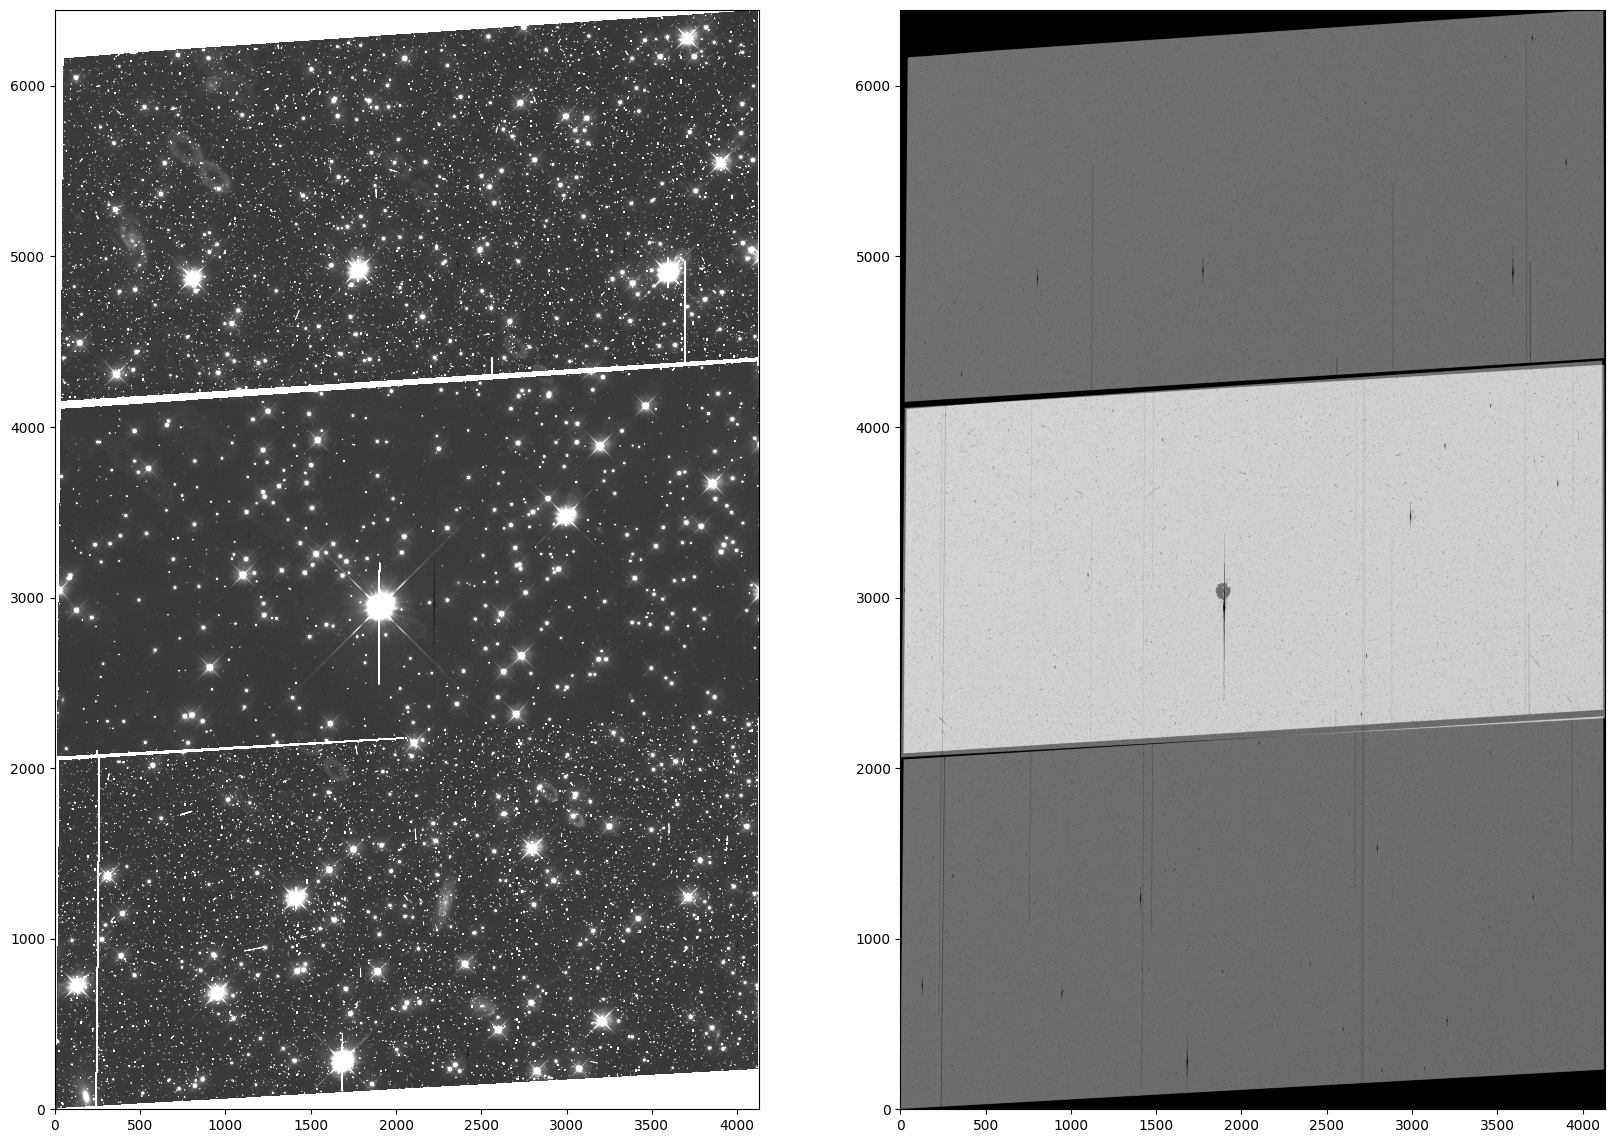

In [25]:
# Display the combined science and weight images 

sci = fits.getdata('f606w_drc_sci.fits')
wht = fits.getdata('f606w_drc_wht.fits')

fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.imshow(sci, vmin=-0.05, vmax=0.4, cmap='Greys_r', origin='lower')
ax2.imshow(wht, vmin=0, vmax=1000, cmap='Greys_r', origin='lower')

## Conclusions

Many other services have interfaces for querying catalogs which could also be used to align HST images.  In general, Gaia works very well for HST due to it's high precision, but can have a low number of sources in some regions, especially at high galactic latitudes.  Aligning images to an absolute frame provides an easy way to make data comparable across many epochs/detectors/observatories, and in many cases, makes the alignment much easier.

# About this Notebook

    Author: V. Bajaj, STScI WFC3 Team
    Updated: December 14, 2018